In [1]:
#%reload_ext autoreload
#%autoreload
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters
from sapsam.SignavioBestPracticesChecker import best_practices_checker
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

# Read Data

Let's first read in the meta data of all models in the dataset.

In [4]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|█████████████████████████████████████████████| 2/2 [00:02<00:00,  1.38s/it]


revision_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  6e9a5e67b18041859a70e093d39f61f5   
18ca3b4ea18f4963ba66d54d209c8df6  526a5b11fcec43c1acae71fc85f6e048   
18ca4a7bbd7a46369bcf6a37b888b6aa  4aa1e97ce2ea4e46a0717333a21b33c9   
18ca6a50c0704715aa48e935f74f2499  aaa3597dc1424b588907ec9aaa79fc4e   
18ca78d943ac434eb03394195d567362  2aa8f762dbb148478358d697be2899de   

                                                   organization_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  b687311ab9944ff4aa57f73ef9c8dd11   
18ca3b4ea18f4963ba66d54d209c8df6  c41660388a04449a995dccf97d894f46   
18ca4a7bbd7a46369bcf6a37b888b6aa  354d0de44863452487e0d586085db660   
18ca6a50c0704715aa48e935f74f2499  d31d0bd9bd92417bbc643f50959d0eb8   
18ca78d943ac434eb03394195d567362  8758cea71ad74736883f3649b47a0957   

                                             datetime description  \
model_id                                                            
18ca3235ecba415da2e24298878ca872  2019-09-03 00:49:15         NaN   
18ca3b4ea18f4963ba66d54d209c8df6  2019-06-12 02:19:30         NaN   
18ca4a7bbd7a46369bcf6a37b888b6aa  2019-09-12 20:30:39         NaN   
18ca6a50c0704715aa48e935f74f2499  2018-05-31 12:15:08         NaN   
18ca78d943ac434eb03394195d567362  2021-09-13 09:02:40         NaN   

                                                                            name  \
model_id                                                                           
18ca3235ecba415da2e24298878ca872                                      Guidelines   
18ca3b4ea18f4963ba66d54d209c8df6                                   12345678_rev1   
18ca4a7bbd7a46369bcf6a37b888b6aa                                   Procure parts   
18ca6a50c0704715aa48e935f74f2499                                   Aufgabe 5.3.2   
18ca78d943ac434eb03394195d567362  Ebene 2 - Prozessbereich: Auftragsdurchführung   

                                 type  \
model_id                                
18ca3235ecba415da2e24298878ca872  NaN   
18ca3b4ea18f4963ba66d54d209c8df6  NaN   
18ca4a7bbd7a46369bcf6a37b888b6aa  NaN   
18ca6a50c0704715aa48e935f74f2499  NaN   
18ca78d943ac434eb03394195d567362  NaN   

                                                                        namespace  
model_id                                                                           
18ca3235ecba415da2e24298878ca872              http://b3mn.org/stencilset/bpmn2.0#  
18ca3b4ea18f4963ba66d54d209c8df6              http://b3mn.org/stencilset/bpmn2.0#  
18ca4a7bbd7a46369bcf6a37b888b6aa              http://b3mn.org/stencilset/bpmn2.0#  
18ca6a50c0704715aa48e935f74f2499  http://www.signavio.com/stencilsets/processmap#  
18ca78d943ac434eb03394195d567362  http://www.signavio.com/stencilsets/processmap#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [5]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [6]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [7]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

9238

This is the percentage of example process from the dataset:

In [8]:
len(df_meta_examples)/len(df_meta)

0.4619

This is the number of models in the dataset without example processes (again, based on process names):

In [9]:
len(df_meta)-len(df_meta_examples)

10762

And the percentage of models in the dataset without example processes:

In [10]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5381

We apply the filter to perform the analysis on the dataset without examples processes:

In [11]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

10762

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [12]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)

We map the namespaces to the common names for the modeling notations.

In [13]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
df_notations = df_notations.replace({'Notation' : d_namespaces})

Now, we have the option to filter the data for the analysis.

In this case, the filter takes between **1** and **3** arguments, where "namespaces" is the filter type.

The **2nd** argument can be an integer, a notation name, or "max". It indicates the number of individual notations that should be kept in the filtered dataset, by descending frequency. The actual notation name can be used, if all others notations should be removed from the dataset.

The **3rd** argument is optional and represents a frequency threshold, under which the corresponding notations will be aggregated into a subgroup "Other".

For example, let's aggregate modeling notations which are used for less than 100 models in "Other".

In [14]:
df_notations = DataFilter(df_notations)
df_notations = df_notations.filter_data("namespaces", "max", 100)
df_notations

Notation  Frequency
0       BPMN 2.0       7861
1            EPC        625
2    Value Chain        482
3       BPMN 1.1        316
4          Other        312
5  UML 2.2 Class        270
6        DMN 1.0        262
7  ArchiMate 2.1        223
8      Petri Net        221
9   UML Use Case        190

We can visualise the number of models in different modeling notations.

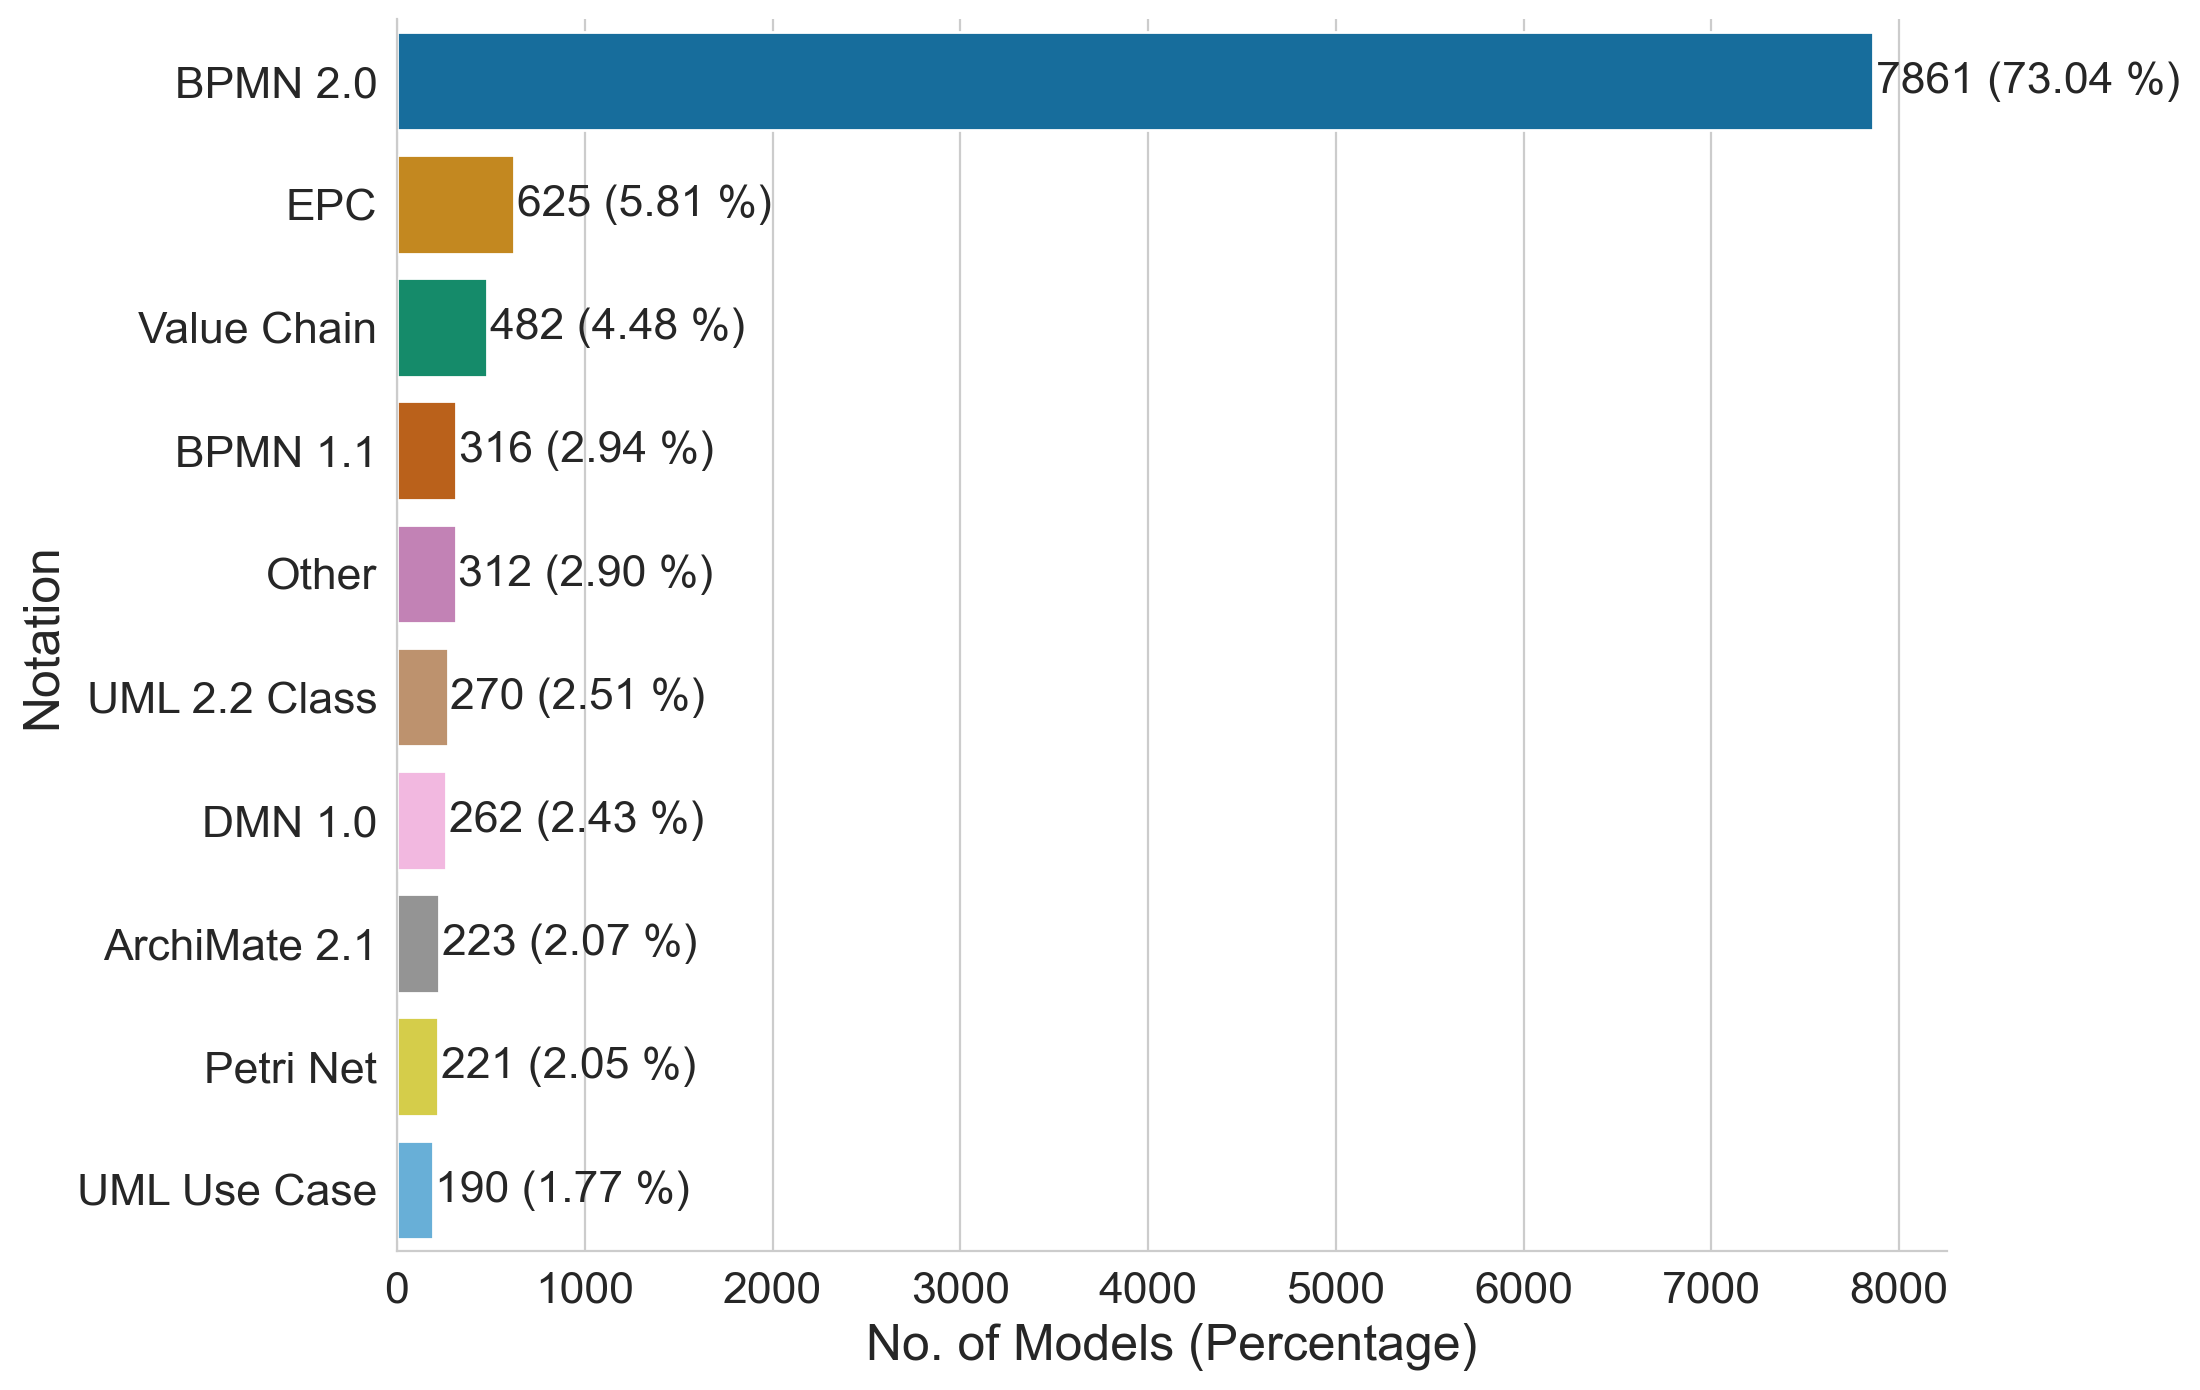

In [15]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
ax=sns.barplot(x="Frequency", y="Notation", data=df_notations, estimator = np.max,ci = 0, palette = sns.color_palette("colorblind"))
#ax=sns.barplot(x="Frequency", y="Notation", hue="Notation", data=df_notations, estimator = np.max, errorbar=('ci', 0), legend=False)
sns.despine()
ax.bar_label(ax.containers[0], label_type='edge', padding=1, labels=[f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
# ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

By using the datetime column, we can also consider the creation of models in different notations over time.

In [16]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [17]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
e89d57f004d44f14ab7810275b1d4583  c24a3c6e1d2d4b3e82a580ab2b99b3b4   

                                                   organization_id  \
model_id                                                             
e89d57f004d44f14ab7810275b1d4583  51d11ffc07f046a88ff02dc14505634c   

                                            datetime description         name  \
model_id                                                                        
e89d57f004d44f14ab7810275b1d4583 2015-10-02 10:20:25         NaN  Proyecto-1P   

                                 type                            namespace  
model_id                                                                    
e89d57f004d44f14ab7810275b1d4583  NaN  http://b3mn.org/stencilset/bpmn2.0#

In [18]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
e8d59482e5c9496182a06afcff1a69b4  54d5bc657fdf44b1bf9cea7cfebb8268   

                                                   organization_id  \
model_id                                                             
e8d59482e5c9496182a06afcff1a69b4  f3d4db0296c34b7b9a231e1703ad949c   

                                            datetime description  \
model_id                                                           
e8d59482e5c9496182a06afcff1a69b4 2021-09-22 00:25:03         NaN   

                                                                     name  \
model_id                                                                    
e8d59482e5c9496182a06afcff1a69b4  Phase 3. Quality Check and Package Post   

                                 type                            namespace  
model_id                                                                    
e8d59482e5c9496182a06afcff1a69b4  NaN  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations. We leave the "Other" subgroup out.

In [19]:
df_notations = DataFilter(df_notations)
selected_notations = df_notations.filter_data("namespaces", 5)
selected_notations['Notation'] = selected_notations['Notation'].map(d_namespaces_reverse)
selected_notations

Notation  Frequency
0              http://b3mn.org/stencilset/bpmn2.0#       7861
1                  http://b3mn.org/stencilset/epc#        625
2  http://www.signavio.com/stencilsets/processmap#        482
3              http://b3mn.org/stencilset/bpmn1.1#        316
4          http://b3mn.org/stencilset/UML2.2Class#        270

In [20]:
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations['Notation'])].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [21]:
df_meta_selected = df_meta_selected.groupby('namespace').resample('Y').sum().reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [22]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected

namespace  Count  Year
0   UML 2.2 Class      7  2015
1   UML 2.2 Class     19  2016
2   UML 2.2 Class     32  2017
3   UML 2.2 Class     34  2018
4   UML 2.2 Class     22  2019
5   UML 2.2 Class     70  2020
6   UML 2.2 Class     86  2021
7        BPMN 1.1      4  2015
8        BPMN 1.1     15  2016
9        BPMN 1.1     29  2017
10       BPMN 1.1     55  2018
11       BPMN 1.1     37  2019
12       BPMN 1.1     73  2020
13       BPMN 1.1    103  2021
14       BPMN 2.0     86  2015
15       BPMN 2.0    327  2016
16       BPMN 2.0    742  2017
17       BPMN 2.0   1357  2018
18       BPMN 2.0   1599  2019
19       BPMN 2.0   1822  2020
20       BPMN 2.0   1928  2021
21            EPC     27  2015
22            EPC     49  2016
23            EPC    107  2017
24            EPC     95  2018
25            EPC     97  2019
26            EPC    160  2020
27            EPC     90  2021
28    Value Chain      2  2015
29    Value Chain     26  2016
30    Value Chain     53  2017
31    Value Chain     99  2018
32    Value Chain     98  2019
33    Value Chain    130  2020
34    Value Chain     74  2021

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [23]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

0

In [24]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2021]
df_meta_selected.head()

namespace  Count  Year
0  UML 2.2 Class      7  2015
1  UML 2.2 Class     19  2016
2  UML 2.2 Class     32  2017
3  UML 2.2 Class     34  2018
4  UML 2.2 Class     22  2019

In [25]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

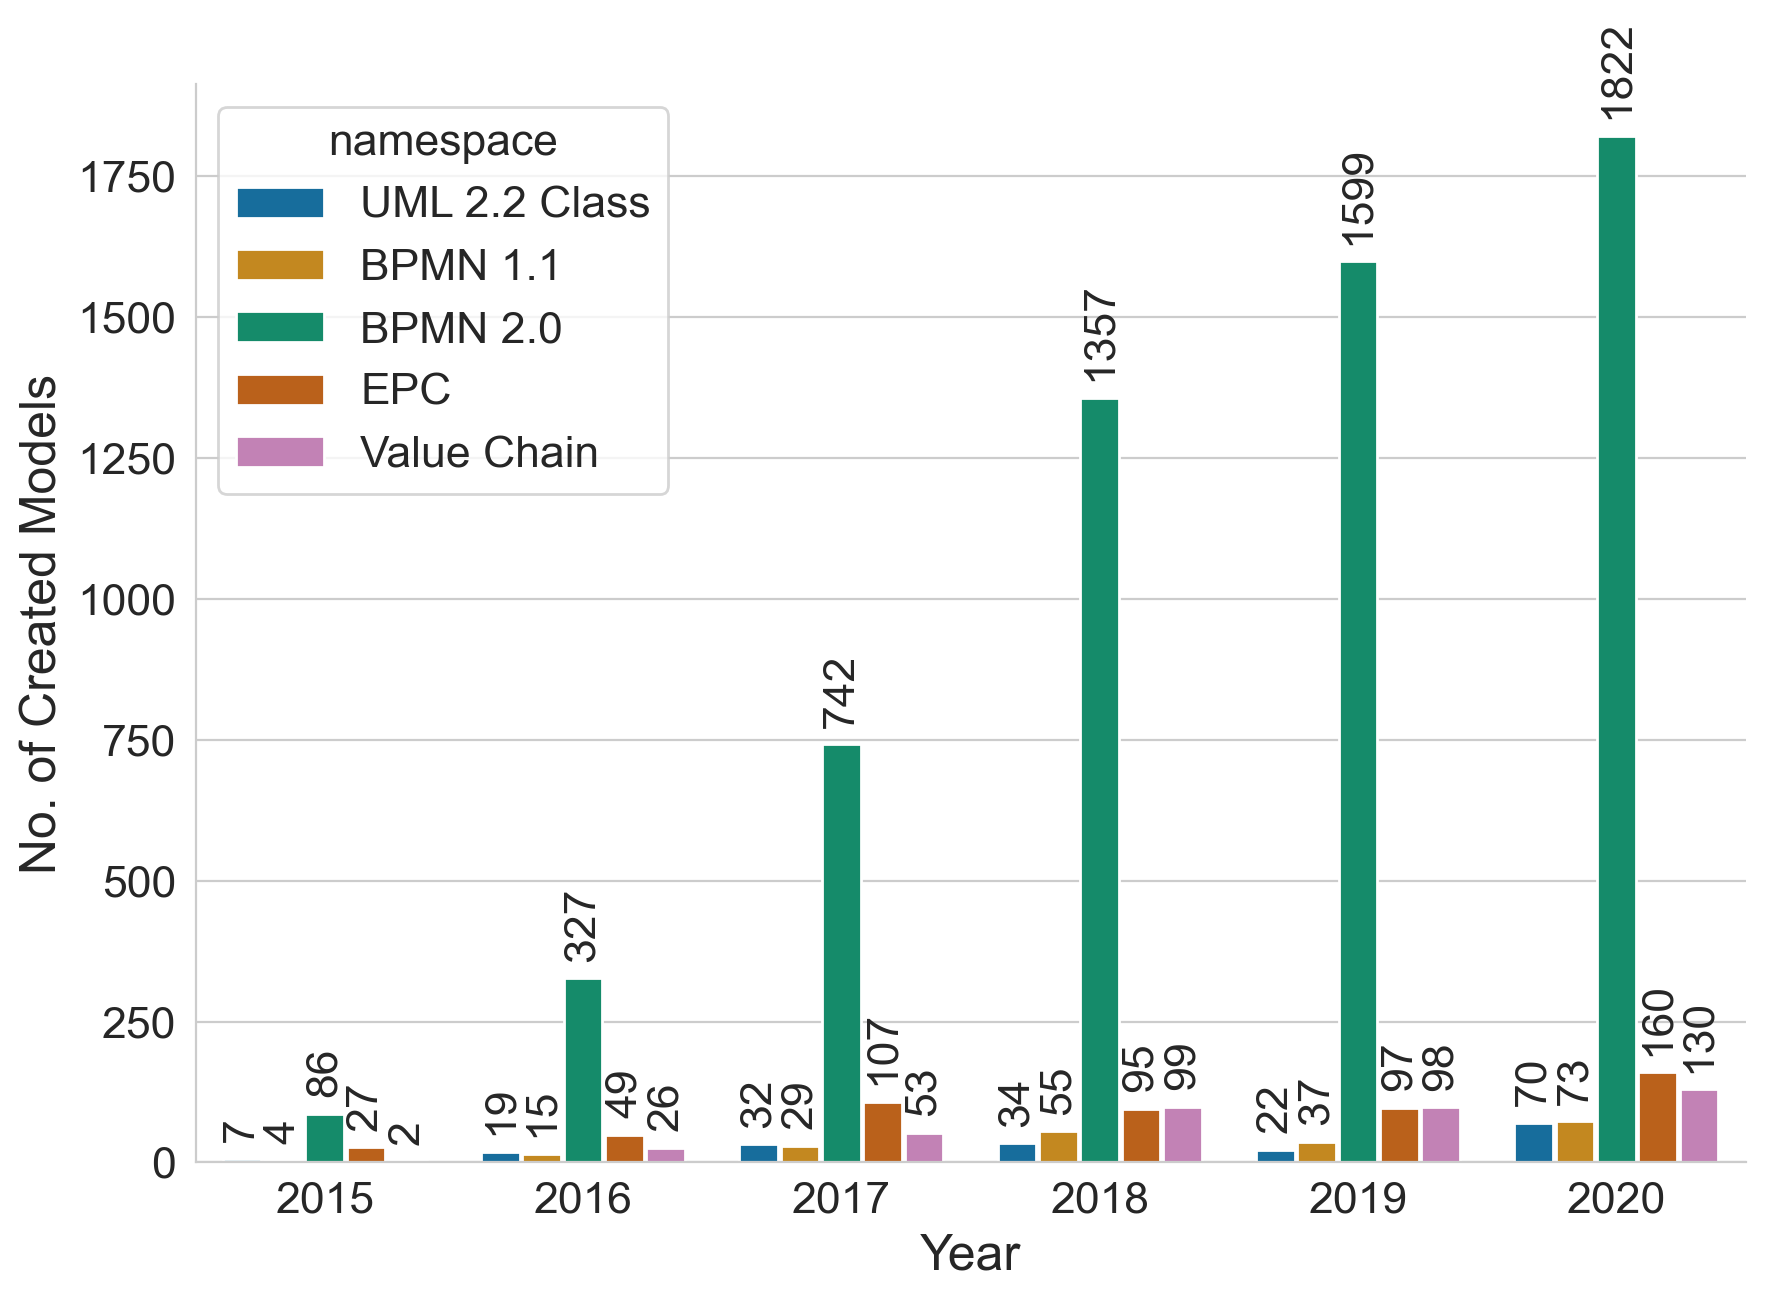

In [26]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax,palette=sns.color_palette("colorblind"))
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [27]:
selected_notations_short = [d_namespaces[n] for n in selected_notations['Notation']]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0  EPC  Value Chain  BPMN 1.1  UML 2.2 Class
2020      1822  160          130        73             70
2019      1599   97           98        37             22
2018      1357   95           99        55             34
2017       742  107           53        29             32
2016       327   49           26        15             19
2015        86   27            2         4              7

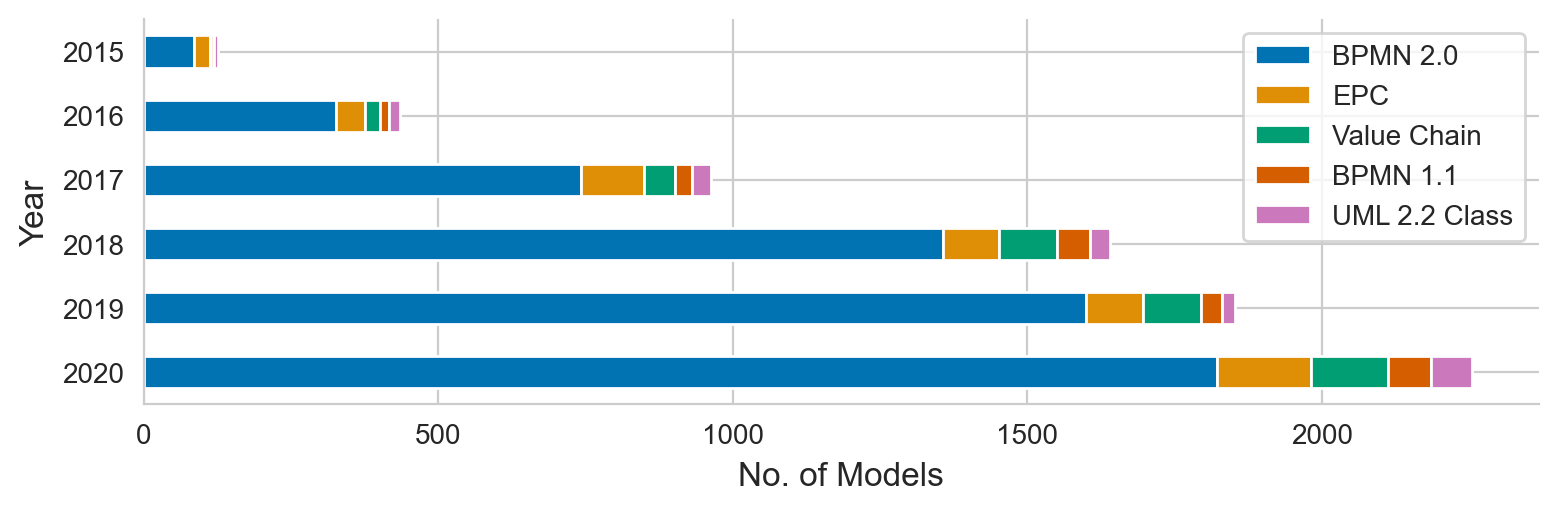

In [28]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [29]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]
df_meta_bpmn.head()

revision_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  6e9a5e67b18041859a70e093d39f61f5   
18ca3b4ea18f4963ba66d54d209c8df6  526a5b11fcec43c1acae71fc85f6e048   
18caebd99fe846daaa9573ca3eba8293  d8fba2417eda4ba08544fcea31a5efeb   
18cb092ef5c64788a7284b0c597fbee8  f0647ea08f944263a482bebe0a0cd2db   
18cb104ce0e341ebad780e6d001342c1  b53ddbff242f45bf96d66facadba8abd   

                                                   organization_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  b687311ab9944ff4aa57f73ef9c8dd11   
18ca3b4ea18f4963ba66d54d209c8df6  c41660388a04449a995dccf97d894f46   
18caebd99fe846daaa9573ca3eba8293  c41660388a04449a995dccf97d894f46   
18cb092ef5c64788a7284b0c597fbee8  9fa5c4b022714032b1343aa6e69b7181   
18cb104ce0e341ebad780e6d001342c1  38ebf1ca95094fbaa4dbf0e7d6572191   

                                            datetime description  \
model_id                                                           
18ca3235ecba415da2e24298878ca872 2019-09-03 00:49:15         NaN   
18ca3b4ea18f4963ba66d54d209c8df6 2019-06-12 02:19:30         NaN   
18caebd99fe846daaa9573ca3eba8293 2019-06-03 20:09:08         NaN   
18cb092ef5c64788a7284b0c597fbee8 2020-05-23 14:48:59         NaN   
18cb104ce0e341ebad780e6d001342c1 2018-04-06 07:35:32         NaN   

                                                     name type  \
model_id                                                         
18ca3235ecba415da2e24298878ca872               Guidelines  NaN   
18ca3b4ea18f4963ba66d54d209c8df6            12345678_rev1  NaN   
18caebd99fe846daaa9573ca3eba8293            12345678_rev3  NaN   
18cb092ef5c64788a7284b0c597fbee8                       35  NaN   
18cb104ce0e341ebad780e6d001342c1  515-IFN-BPM Assignment1  NaN   

                                                            namespace  
model_id                                                               
18ca3235ecba415da2e24298878ca872  http://b3mn.org/stencilset/bpmn2.0#  
18ca3b4ea18f4963ba66d54d209c8df6  http://b3mn.org/stencilset/bpmn2.0#  
18caebd99fe846daaa9573ca3eba8293  http://b3mn.org/stencilset/bpmn2.0#  
18cb092ef5c64788a7284b0c597fbee8  http://b3mn.org/stencilset/bpmn2.0#  
18cb104ce0e341ebad780e6d001342c1  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models:

In [30]:
len(df_meta_bpmn)

7861

We use the BPMNModelParser to parse the BPMN 2.0 models. In case we have already parsed them, we load the parsed data from the pkl file.

In [31]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
#df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|█████████████████████████████████████████████| 2/2 [00:23<00:00, 11.82s/it]


category  \
model_id                         element_id                                               
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6  SequenceFlow   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541  SequenceFlow   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC  SequenceFlow   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F  SequenceFlow   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127  SequenceFlow   

                                                                          label  \
model_id                         element_id                                       
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6   Yes   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541    No   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC    No   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F   Yes   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6             None   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541             None   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC             None   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F             None   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127             None   

                                                                                 name  
model_id                         element_id                                            
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6  Guidelines  
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541  Guidelines  
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC  Guidelines  
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F  Guidelines  
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127  Guidelines

In [32]:
df_meta_bpmn.head()

revision_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  6e9a5e67b18041859a70e093d39f61f5   
18ca3b4ea18f4963ba66d54d209c8df6  526a5b11fcec43c1acae71fc85f6e048   
18caebd99fe846daaa9573ca3eba8293  d8fba2417eda4ba08544fcea31a5efeb   
18cb092ef5c64788a7284b0c597fbee8  f0647ea08f944263a482bebe0a0cd2db   
18cb104ce0e341ebad780e6d001342c1  b53ddbff242f45bf96d66facadba8abd   

                                                   organization_id  \
model_id                                                             
18ca3235ecba415da2e24298878ca872  b687311ab9944ff4aa57f73ef9c8dd11   
18ca3b4ea18f4963ba66d54d209c8df6  c41660388a04449a995dccf97d894f46   
18caebd99fe846daaa9573ca3eba8293  c41660388a04449a995dccf97d894f46   
18cb092ef5c64788a7284b0c597fbee8  9fa5c4b022714032b1343aa6e69b7181   
18cb104ce0e341ebad780e6d001342c1  38ebf1ca95094fbaa4dbf0e7d6572191   

                                            datetime description  \
model_id                                                           
18ca3235ecba415da2e24298878ca872 2019-09-03 00:49:15         NaN   
18ca3b4ea18f4963ba66d54d209c8df6 2019-06-12 02:19:30         NaN   
18caebd99fe846daaa9573ca3eba8293 2019-06-03 20:09:08         NaN   
18cb092ef5c64788a7284b0c597fbee8 2020-05-23 14:48:59         NaN   
18cb104ce0e341ebad780e6d001342c1 2018-04-06 07:35:32         NaN   

                                                     name type  \
model_id                                                         
18ca3235ecba415da2e24298878ca872               Guidelines  NaN   
18ca3b4ea18f4963ba66d54d209c8df6            12345678_rev1  NaN   
18caebd99fe846daaa9573ca3eba8293            12345678_rev3  NaN   
18cb092ef5c64788a7284b0c597fbee8                       35  NaN   
18cb104ce0e341ebad780e6d001342c1  515-IFN-BPM Assignment1  NaN   

                                                            namespace  
model_id                                                               
18ca3235ecba415da2e24298878ca872  http://b3mn.org/stencilset/bpmn2.0#  
18ca3b4ea18f4963ba66d54d209c8df6  http://b3mn.org/stencilset/bpmn2.0#  
18caebd99fe846daaa9573ca3eba8293  http://b3mn.org/stencilset/bpmn2.0#  
18cb092ef5c64788a7284b0c597fbee8  http://b3mn.org/stencilset/bpmn2.0#  
18cb104ce0e341ebad780e6d001342c1  http://b3mn.org/stencilset/bpmn2.0#

Number of BPMN 2.0 models from the parser:

In [33]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

11801

Number of BPMN 2.0 models from the parser after filtering out example processes:

In [34]:
df_bpmn = DataFilter(df_bpmn)
df_bpmn = df_bpmn.filter_data("example_processes")
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

7624

When compared to the analysis of the dataset metadata, we notice the count of BPMN 2.0 models is slightly lower. This difference shows that there are some empty BPMN 2.0 models in the dataset which do not contain any elements, and thus ignored during the parsing.

The total number of elements from all BPMN 2.0 models is:

In [35]:
len(df_bpmn)

387909

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [36]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    #!pip install update -U pydantic==1.10.8
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✓ Download and installation successful


In [37]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|███████████████████████████████████████| 7624/7624 [02:12<00:00, 57.40it/s]


label  \
model_id                                                                              
18ca3235ecba415da2e24298878ca872  Yes No  Any enhancement\n required? Adjust the...   
18ca3b4ea18f4963ba66d54d209c8df6   invoice amount\n> $5000 ACME Inc. Department ...   
18caebd99fe846daaa9573ca3eba8293   NE 2 dny 0desl?n? vzork? do CL na testy Ano D...   
18cb092ef5c64788a7284b0c597fbee8   Nominados Medicine nobel prize committee Reco...   
18cb104ce0e341ebad780e6d001342c1   Received  \ncustomer\n profile Email \ncustom...   

                                                     name  \
model_id                                                    
18ca3235ecba415da2e24298878ca872               Guidelines   
18ca3b4ea18f4963ba66d54d209c8df6            12345678_rev1   
18caebd99fe846daaa9573ca3eba8293            12345678_rev3   
18cb092ef5c64788a7284b0c597fbee8                       35   
18cb104ce0e341ebad780e6d001342c1  515-IFN-BPM Assignment1   

                                 detected_natural_language  
model_id                                                    
18ca3235ecba415da2e24298878ca872                        en  
18ca3b4ea18f4963ba66d54d209c8df6                        en  
18caebd99fe846daaa9573ca3eba8293                        cs  
18cb092ef5c64788a7284b0c597fbee8                        es  
18cb104ce0e341ebad780e6d001342c1                        en

Let's plot the use of different languages across the dataset.

In [38]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [39]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English           3547
1                       German           2118
2                      Italian            376
3                      Spanish            333
4                     Croatian            183
5                       French            165
6                   Portuguese            123
7                        Dutch            108
8                    Slovenian            105
9                     Estonian             89
10  Unknown language [UNKNOWN]             79
11                    Romanian             79
12                  Indonesian             62
13                     Swedish             38
14                   Hungarian             35
15                       Greek             31
16                      Polish             25
17                     Turkish             13
18                  Vietnamese             12
19                     Finnish             11
20                      Danish             11
21                       Czech             10
22                    Albanian              9
23                    Japanese              8
24                       Welsh              7
25                   Afrikaans              7
26                   Norwegian              6
27                     Tagalog              6
28    Unknown language [zh-cn]              5
29                      Slovak              5
30                      Somali              4
31                     Latvian              4
32                     Catalan              3
33                  Lithuanian              2
34                     Russian              2
35                      Korean              2
36                  Macedonian              1

We only plot the 10 most common languages.

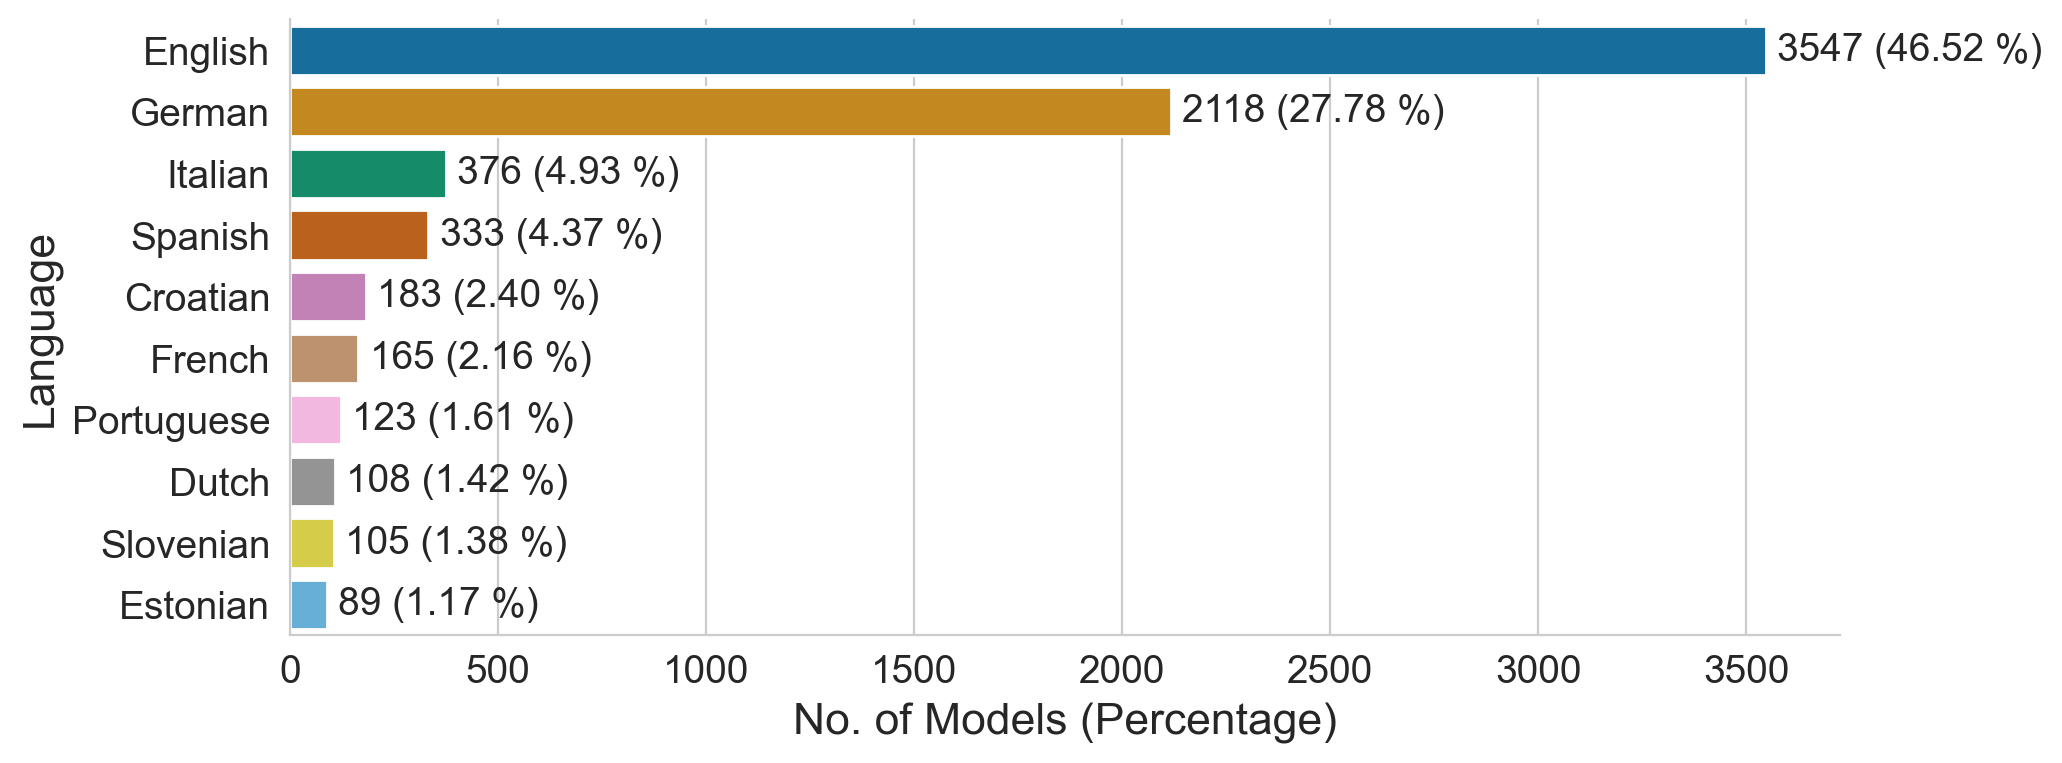

In [40]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:nr_most_common]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", data=df_lang,palette=sns.color_palette("colorblind"))
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']])
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Next, we want to examine the usage of element types in the BPMN models.

In [41]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [42]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|█████████████████████████████████████| 7624/7624 [00:04<00:00, 1767.18it/s]


SequenceFlow  Exclusive_Databased_Gateway  Task  EndNoneEvent  \
0            14                            3     8             1   
1             8                            2     4             1   
2            10                            2     5             1   
3             0                            0     1             0   
4            12                            1     5             1   

   StartNoneEvent  total_count  Association_Undirected  Pool  Lane  ITSystem  \
0               1           27                       0     0     0         0   
1               0           25                       3     1     3         2   
2               0           29                       2     0     0         0   
3               0            5                       0     1     1         0   
4               1           32                       0     1     2         0   

   IntermediateLinkEventCatching  IntermediateEvent  \
0                              0                  0   
1                              1                  0   
2                              0                  2   
3                              0                  0   
4                              0                  0   

   Association_Unidirectional  DataObject  TextAnnotation  StartTimerEvent  \
0                           0           0               0                0   
1                           0           0               0                0   
2                           2           2               2                1   
3                           0           0               0                0   
4                           1           1               0                0   

   MessageFlow  CollapsedPool  Association_Bidirectional  CollapsedSubprocess  \
0            0              0                          0                    0   
1            0              0                          0                    0   
2            0              0                          0                    0   
3            1              1                          0                    0   
4            0              0                          2                    2   

   DataStore  IntermediateMessageEventThrowing  \
0          0                                 0   
1          0                                 0   
2          0                                 0   
3          0                                 0   
4          1                                 1   

   IntermediateMessageEventCatching  StartMessageEvent  \
0                                 0                  0   
1                                 0                  0   
2                                 0                  0   
3                                 0                  0   
4                                 1                  0   

   IntermediateConditionalEvent  IntermediateTimerEvent  EventbasedGateway  \
0                             0                       0                  0   
1                             0                       0                  0   
2                             0                       0                  0   
3                             0                       0                  0   
4                             0                       0                  0   

   EndMessageEvent  ParallelGateway  InclusiveGateway  EndTerminateEvent  \
0                0                0                 0                  0   
1                0                0                 0                  0   
2                0                0                 0                  0   
3                0                0                 0                  0   
4                0                0                 0                  0   

   IntermediateMultipleEventCatching  VerticalPool  VerticalLane  \
0                                  0             0             0   
1                                  0             0             0   
2                                  0          

These are the statistics of the different element types per model:

In [43]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    7624.000000
mean       10.012592
std         4.179132
min         1.000000
25%         7.000000
50%         9.000000
75%        13.000000
max        34.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [44]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
0a1ef88d340b4d6d9d5faec06083ca60                          0   
0a1f112af2a7492daffec5bb0e96be40                          0   
0a1f37872dcb490682b5cb4c5bdcc7a2                          0   
0a1f6515f7cb4da98ff9534b5340bb7e                          0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                          0   

category                          Association_Undirected  \
model_id                                                   
0a1ef88d340b4d6d9d5faec06083ca60                       0   
0a1f112af2a7492daffec5bb0e96be40                       0   
0a1f37872dcb490682b5cb4c5bdcc7a2                       1   
0a1f6515f7cb4da98ff9534b5340bb7e                       0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                       1   

category                          Association_Unidirectional  \
model_id                                                       
0a1ef88d340b4d6d9d5faec06083ca60                           0   
0a1f112af2a7492daffec5bb0e96be40                           2   
0a1f37872dcb490682b5cb4c5bdcc7a2                           0   
0a1f6515f7cb4da98ff9534b5340bb7e                           0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                           0   

category                          ChoreographyParticipant  ChoreographyTask  \
model_id                                                                      
0a1ef88d340b4d6d9d5faec06083ca60                        0                 0   
0a1f112af2a7492daffec5bb0e96be40                        0                 0   
0a1f37872dcb490682b5cb4c5bdcc7a2                        0                 0   
0a1f6515f7cb4da98ff9534b5340bb7e                        0                 0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                        0                 0   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
0a1ef88d340b4d6d9d5faec06083ca60                         0              0   
0a1f112af2a7492daffec5bb0e96be40                         0              0   
0a1f37872dcb490682b5cb4c5bdcc7a2                         0              1   
0a1f6515f7cb4da98ff9534b5340bb7e                         0              3   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                         0              0   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
0a1ef88d340b4d6d9d5faec06083ca60                    0                      0   
0a1f112af2a7492daffec5bb0e96be40                    0                      0   
0a1f37872dcb490682b5cb4c5bdcc7a2                    1                      0   
0a1f6515f7cb4da98ff9534b5340bb7e                    0                      0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c                    0                      0   

category                          ComplexGateway  DataObject  DataStore  \
model_id                                                                  
0a1ef88d340b4d6d9d5faec06083ca60               0           0          0   
0a1f112af2a7492daffec5bb0e96be40               0           0          0   
0a1f37872dcb490682b5cb4c5bdcc7a2               0           0          0   
0a1f6515f7cb4da98ff9534b5340bb7e               0           0          0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c               0           0          0   

category                          EndCancelEvent  EndCompensationEvent  \
model_id                                                                 
0a1ef88d340b4d6d9d5faec06083ca60               0                     0   
0a1f112af2a7492daffec5bb0e96be40               0                     0   
0a1f37872dcb490682b5cb4c5bdcc7a2               0                     0   
0a1f6515f7cb4da98ff9534b5340bb7e               0                     0   
0a1f6a48a89446fe8d4bcdb5fb1c1f6c               0               

In [45]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [46]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
len(df_freq[df_freq["frequency"]/len(df_cnts) < 0.1])

44

In [47]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())
df_freq.head()

category  frequency
0                  Sequence flow       7501
1                           Task       7397
2                 End none event       6715
3               Start none event       5887
4  Exclusive  databased  gateway       5777

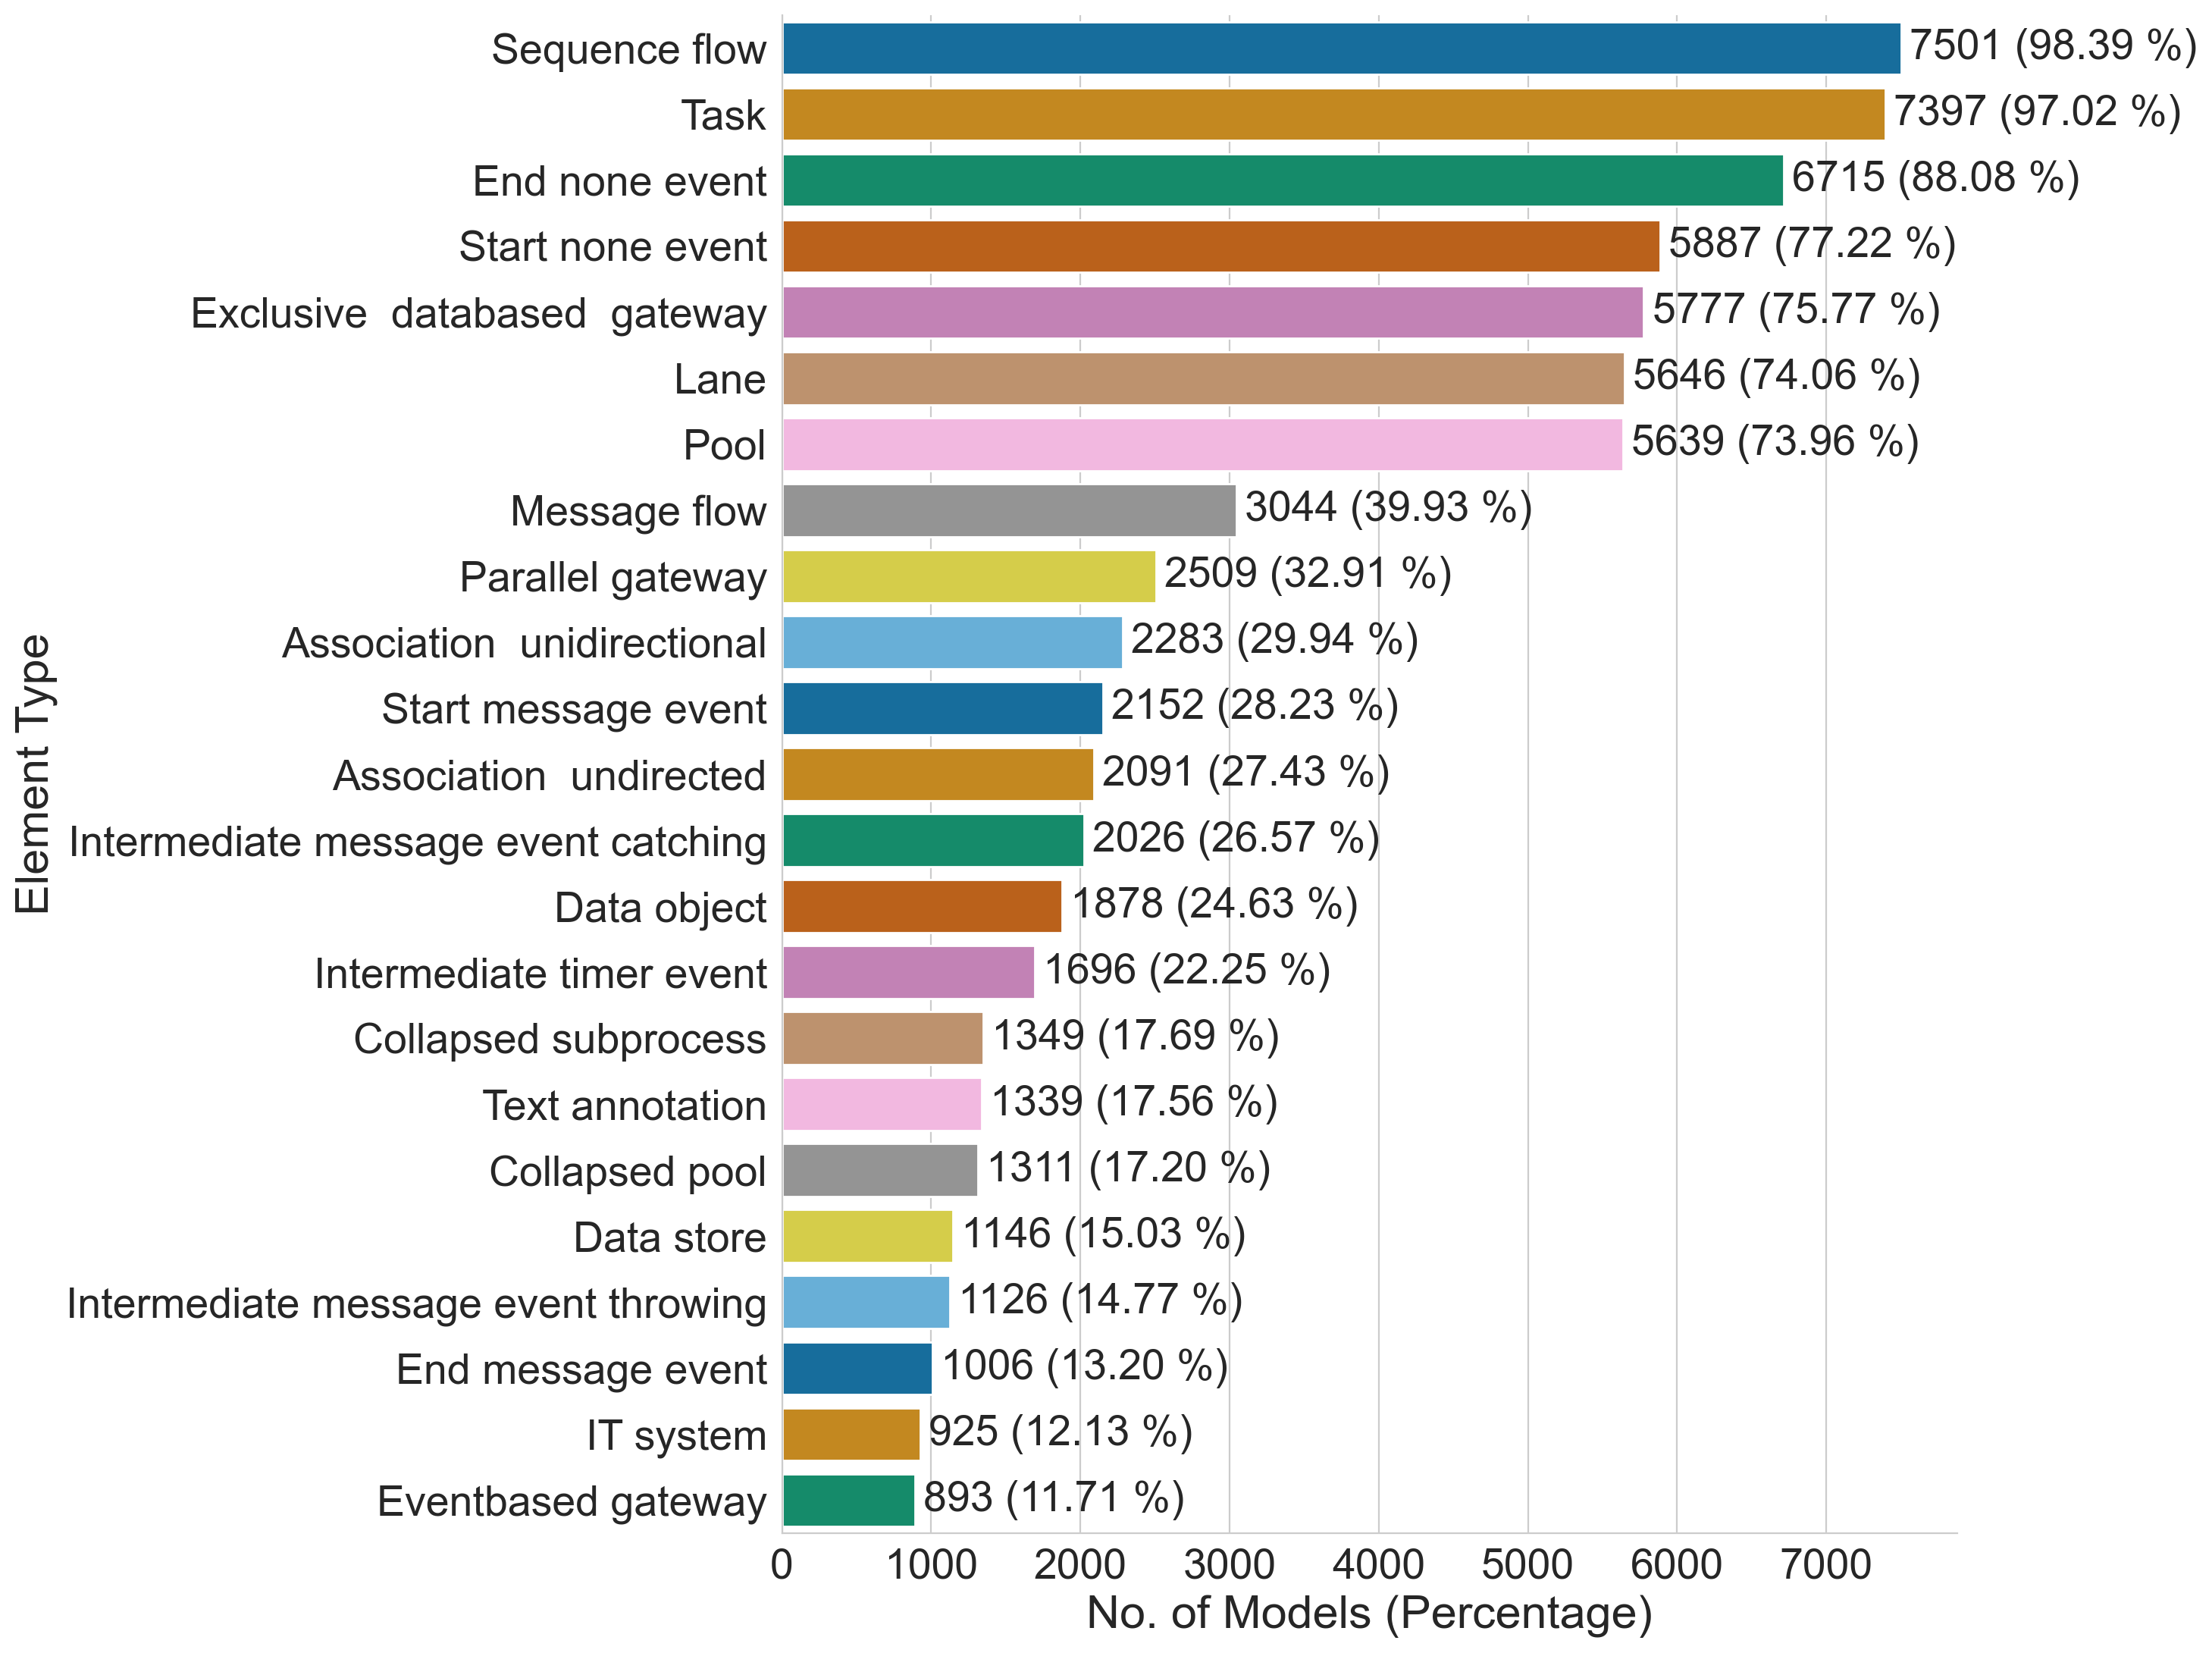

In [48]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
ax = sns.barplot(x="frequency", y="category", data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind"));
total = len(df_cnts)
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_freq['frequency']])
sns.despine()
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Business objects

Now, let's take a look at business objects in BPMN 2.0 diagrams, also known as dictionary items or glossary entries. The dictionary is a Signavio feature that allows the user to enable reusability of BPMN diagram elements by dragging them out of a list, instead of having to recreate them for each diagram. That way, the creation of diagrams is made less time consuming, while also ensuring name and attributes consistency for elements that are recurrent through an organisation's processes (for example, IT system).

In [49]:
df_bpmn.head()

category  \
model_id                         element_id                                               
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6  SequenceFlow   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541  SequenceFlow   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC  SequenceFlow   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F  SequenceFlow   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127  SequenceFlow   

                                                                          label  \
model_id                         element_id                                       
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6   Yes   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541    No   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC    No   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F   Yes   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127         

                                                                          glossary_link_id  \
model_id                         element_id                                                  
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6             None   
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541             None   
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC             None   
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F             None   
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127             None   

                                                                                 name  
model_id                         element_id                                            
18ca3235ecba415da2e24298878ca872 sid-70639531-3826-4276-A012-021333AE9CA6  Guidelines  
                                 sid-597E2F05-6C44-47E1-8BB4-7FA963259541  Guidelines  
                                 sid-48A81477-A890-4C3A-BEF1-FC8F3106C5BC  Guidelines  
                                 sid-61DFEC44-CD30-48C9-88AB-20EE3AB0711F  Guidelines  
                                 sid-FB6F3002-83D5-4F26-8890-0F0487356127  Guidelines

First, we calculate and visualize the total counts of business objects in the dataset.

In [50]:
total_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") & (df_bpmn['glossary_link_id'] != "None")]

This give us a total count of:

In [51]:
total_bos_count = len(total_bos)
total_bos_count

2752

When compared to the total number of elements, that would be about:

In [52]:
print(f"{round(total_bos_count/len(df_bpmn)*100, 2)}%")

0.71%


Next, let's take a look at how many models have at least one glossary link.

In [53]:
models_w_bos = df_bpmn[(df_bpmn['glossary_link_id'] != "") 
    & (df_bpmn['glossary_link_id'] != "None")].groupby(level=['model_id']).size()

This is the number of models with at least one element from the dictionary:

In [54]:
len(models_w_bos)

864

The highest number of glossary links used in one model:

In [55]:
models_w_bos.max()

83

Now, let's take a look at how many unique glossary items are present in the dataset, and compare it to the overall count.

In [56]:
unique_bo_ids_count = len(df_bpmn['glossary_link_id'].unique())
unique_bo_ids_count

1937

In [57]:
print(f"{round(unique_bo_ids_count/total_bos_count*100, 2)}%")

70.39%


This is the percentage of unique glossary items in the dataset. In other terms, it gives us a rough idea of how often dictionary items are being reused in the models.

We also want to find out what is the most used type of dictionary item. For that, we create a plot:

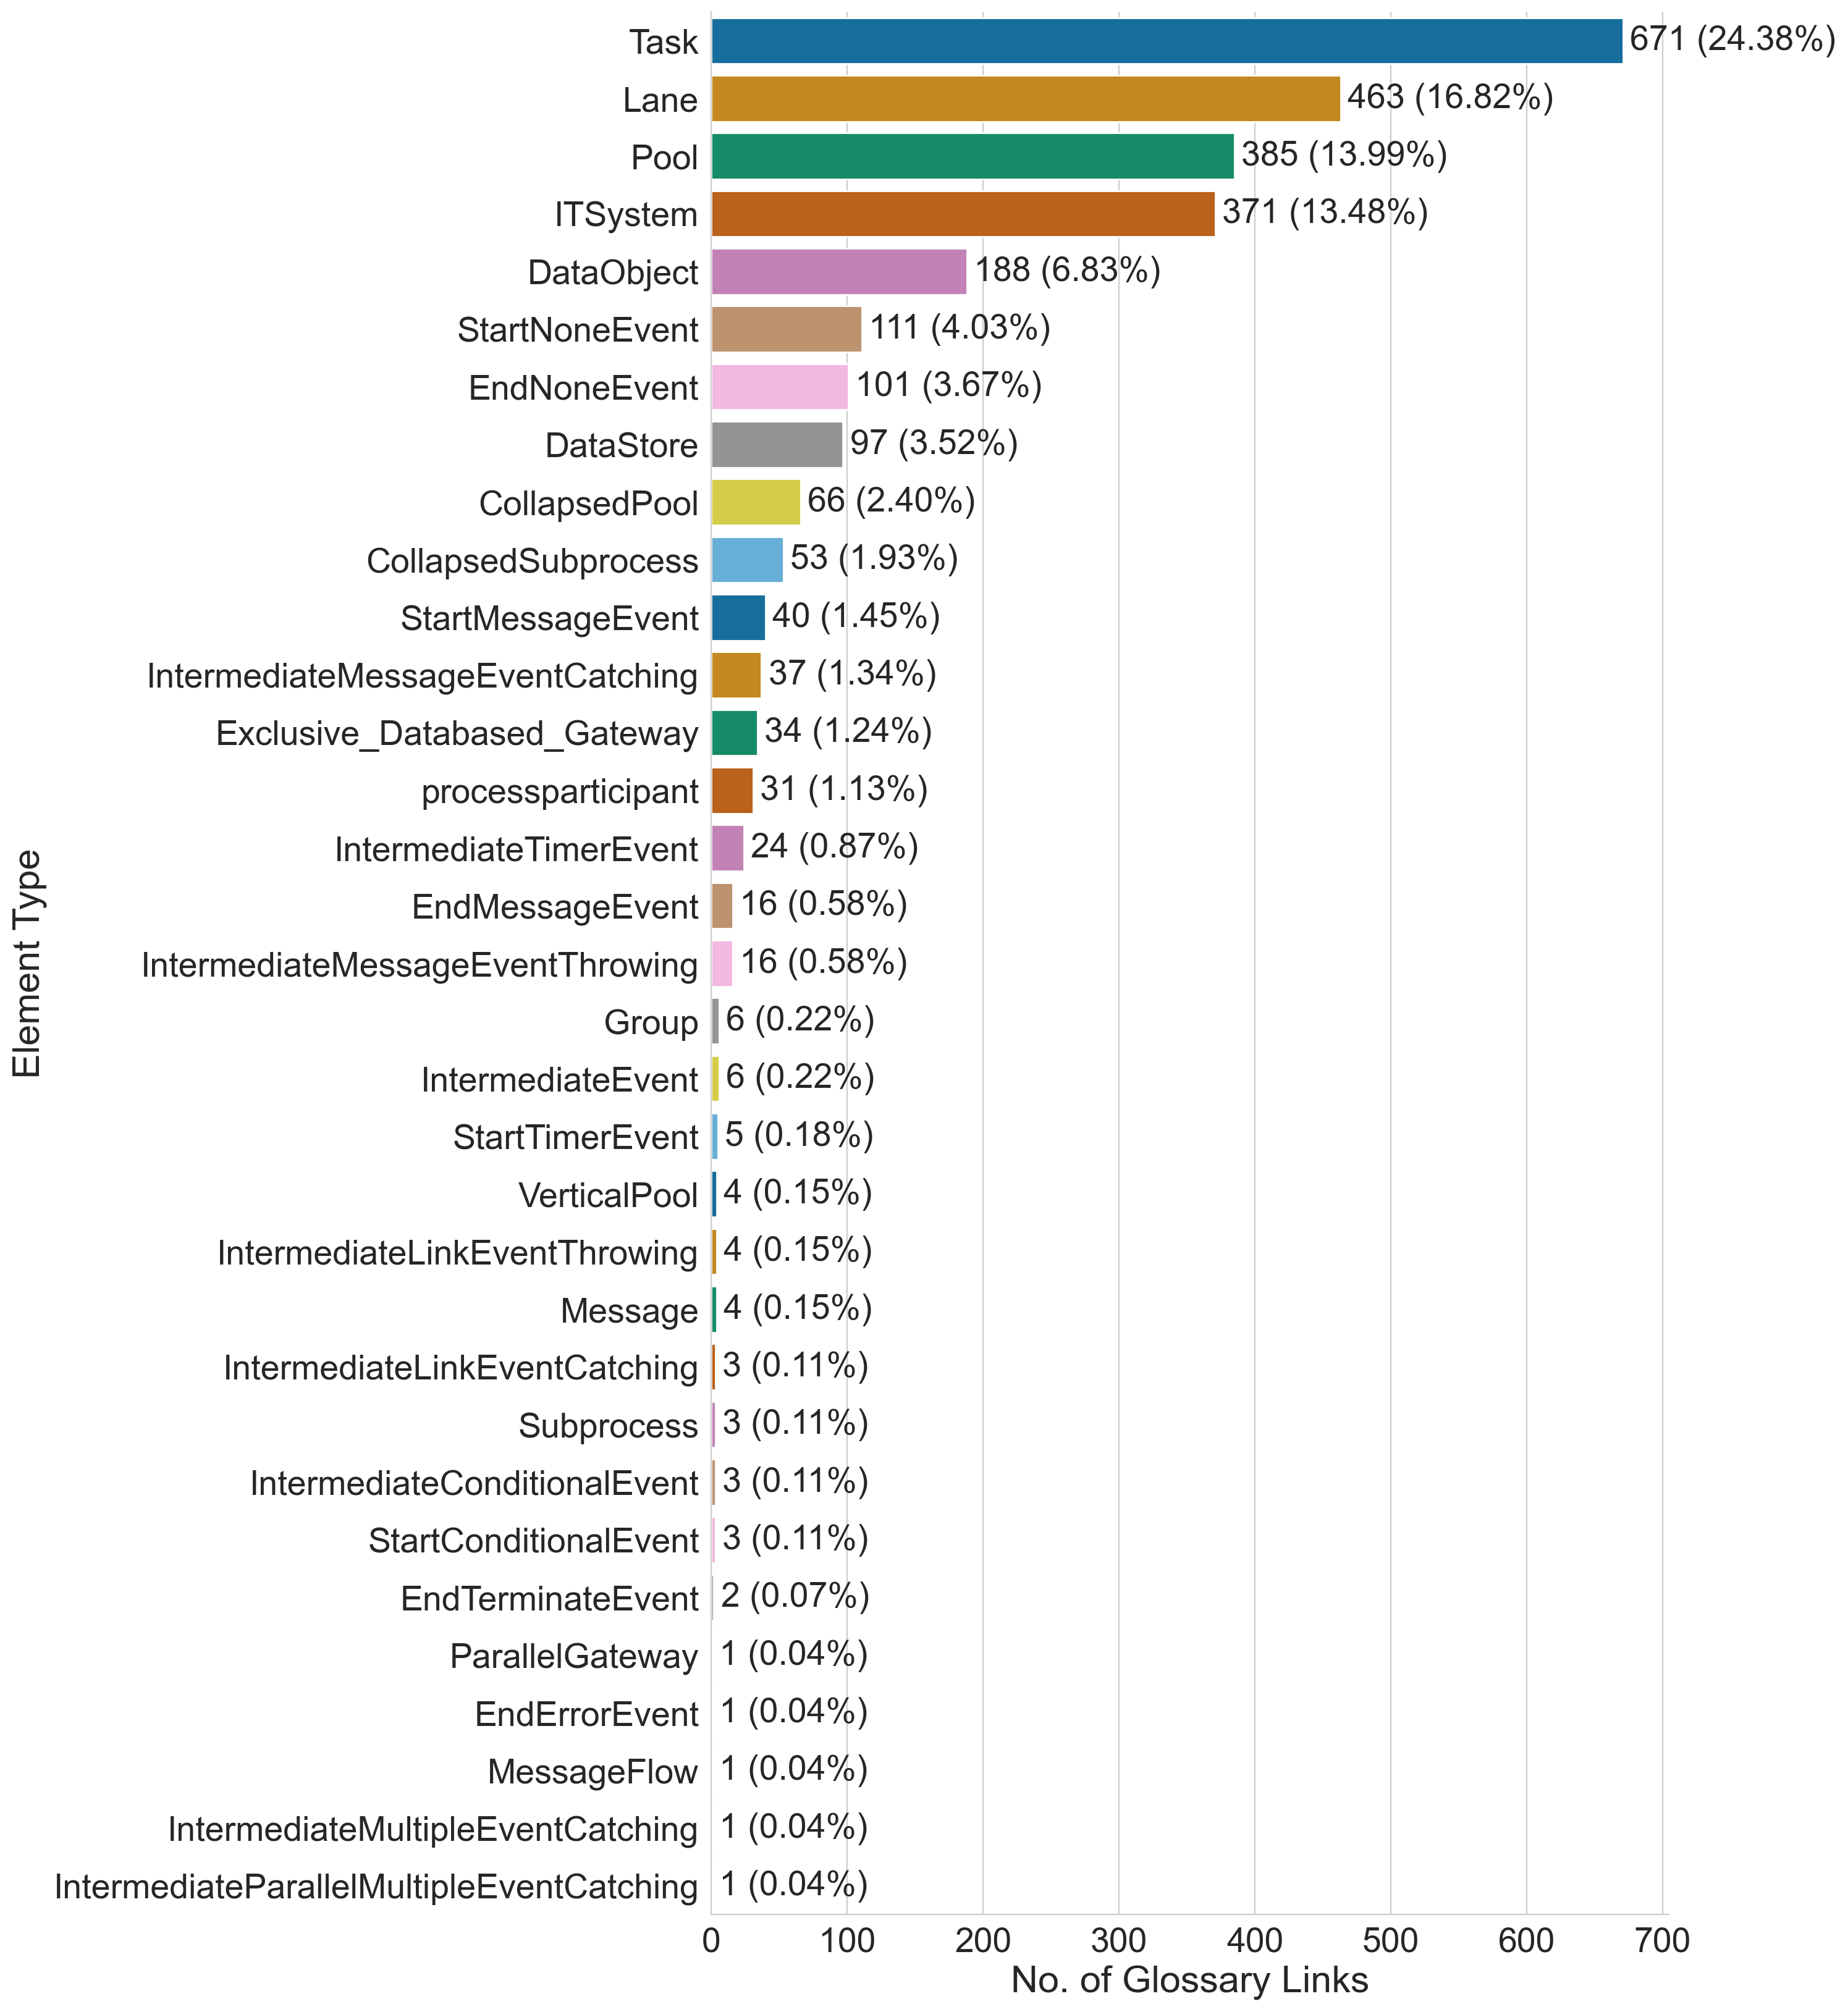

<Figure size 640x480 with 0 Axes>

In [58]:
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 20})
ax = sns.countplot(y="category", data=total_bos, order=total_bos['category'].value_counts().index,palette=sns.color_palette("colorblind"))
total = total_bos_count
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val.get_width()} ({val.get_width()/total*100.0:.2f}%)' for val in ax.containers[0]])
sns.despine()
ax.set_xlabel("No. of Glossary Links",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.show()
plt.savefig(constants.FIGURES_ROOT / 'glossary_elements_usage.pdf',transparent=True,bbox_inches = 'tight')

For the next analysis, let's concentrate on one particularly interesting category, 'ITSystem'. First, let's see how many models with 'ITSystem' entries we have in the dataset. In this way, we can evaluate how many different IT systems a process model is using.

In [59]:
its_bos = total_bos[total_bos['category'] == 'ITSystem']
its_bos = its_bos.reset_index()
its_bos_count = its_bos.groupby('model_id')['glossary_link_id'].count().reset_index()

This is the count of models using at least one dictionary item of type 'ITSystem' in the dataset.

In [60]:
len(its_bos_count)

170

Let's plot the distribution of these glossary entries across models. For the sake of readability, we aggregate all models using more than 7 IT Systems elements in the 'Other' category.

In [61]:
its_count_per_model = its_bos_count['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

170


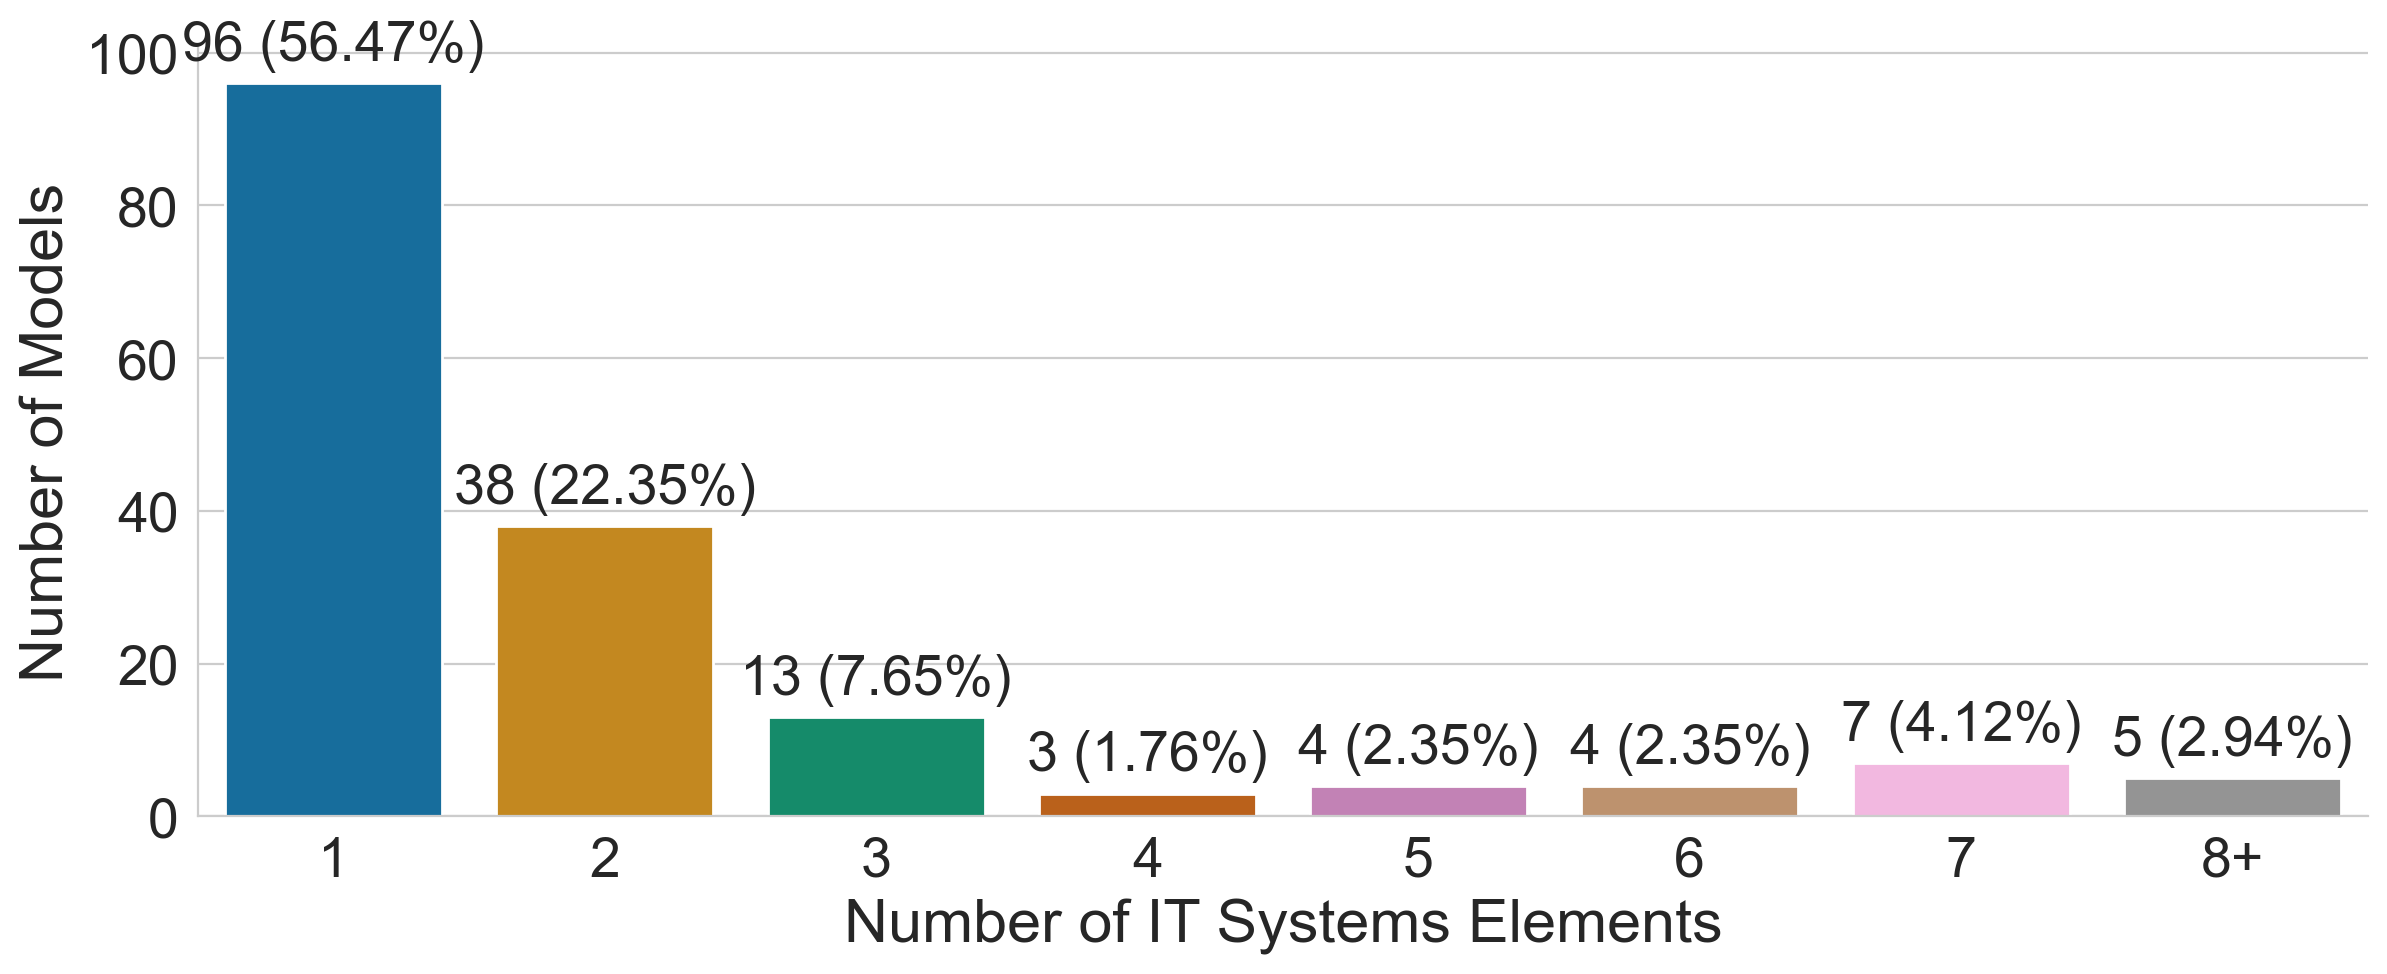

<Figure size 640x480 with 0 Axes>

In [62]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,palette=sns.color_palette("colorblind"))
total = len(its_bos_count)
print(total)
ax.bar_label(ax.containers[0],label_type='edge', padding=4,labels=[f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values])
sns.despine()
ax.set_xlabel("Number of IT Systems Elements",fontsize=22)
ax.set_ylabel("Number of Models",fontsize=22)
plt.show()
plt.savefig(constants.FIGURES_ROOT / 'distribution_itsystems.pdf',transparent=True,bbox_inches = 'tight')

Now, let's see how many of these IT Systems might in fact be referring to the same item, but involved at different stages of the process modelling.

In [63]:
its_bos = its_bos.groupby('model_id')['glossary_link_id'].nunique().reset_index()
its_count_per_model = its_bos['glossary_link_id'].value_counts().sort_index()
its_count_per_model.index = its_count_per_model.index.where(its_count_per_model.index < 8, '8+')
its_count_per_model = its_count_per_model.groupby(its_count_per_model.index).sum()

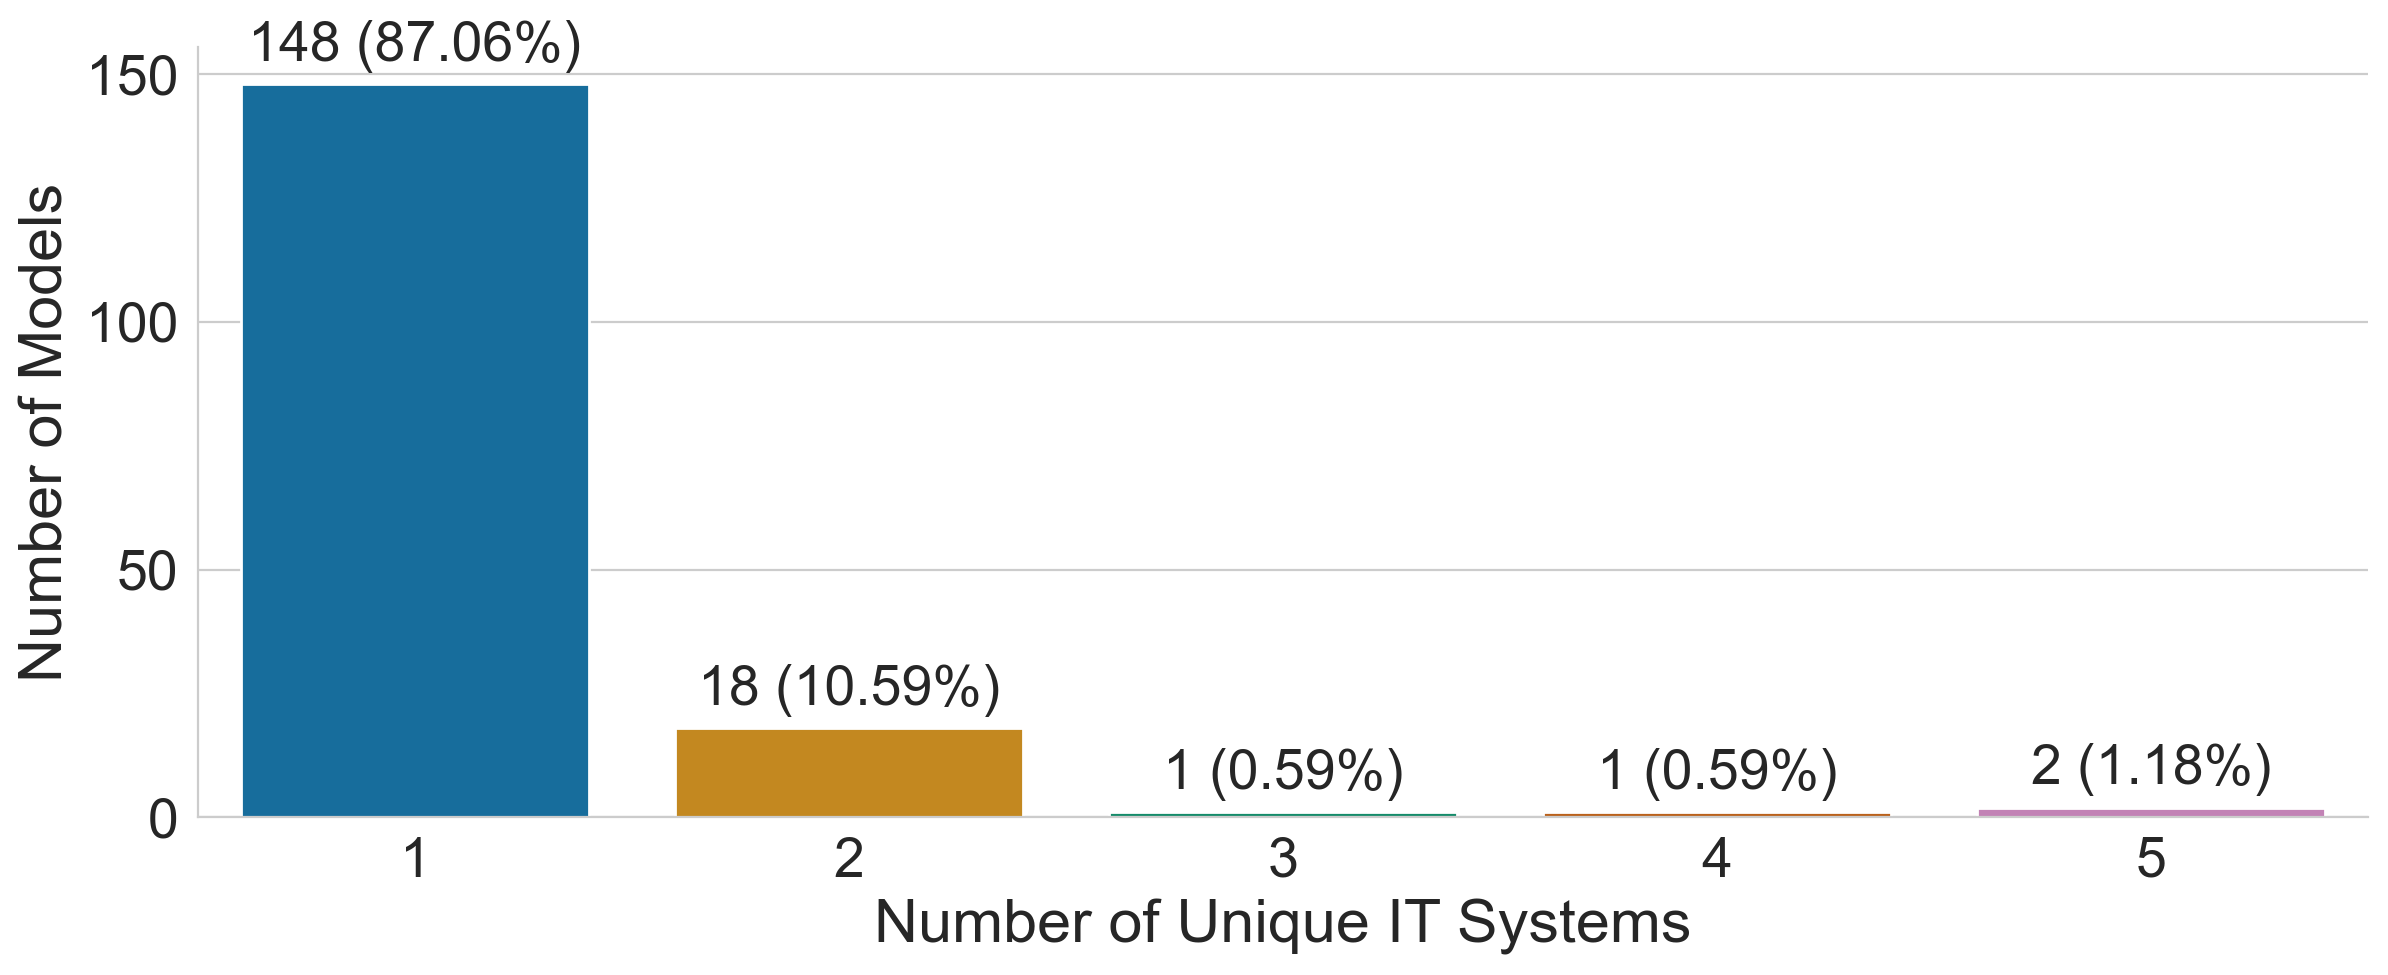

<Figure size 640x480 with 0 Axes>

In [64]:
plt.figure(figsize=(14, 5))
ax = sns.barplot(x=its_count_per_model.index,y=its_count_per_model.values,palette=sns.color_palette("colorblind"))
total = len(its_bos)
ax.bar_label(ax.containers[0],label_type='edge',padding=4,labels=[f'{val} ({val/total*100.0:.2f}%)' for val in its_count_per_model.values])
sns.despine()
ax.set_xlabel("Number of Unique IT Systems",fontsize=22)
ax.set_ylabel("Number of Models",fontsize=22)
plt.show()
plt.savefig(constants.FIGURES_ROOT / 'distribution_unique_itsystems.pdf',transparent=True,bbox_inches = 'tight')

As a conclusion, we can observe that an overwhelming majority of models is using only one IT System, regardless of the number of times it is involved in a single process model.

# Elements

These are the statistics of the number of elements per model:

In [65]:
cnt_elements.total_count.describe()

count    7624.000000
mean       50.879984
std        48.512269
min         1.000000
25%        23.000000
50%        39.000000
75%        63.000000
max       909.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [66]:
cnt_elements.describe().transpose()

count       mean        std  min  \
SequenceFlow                               7624.0  20.159103  19.592182  0.0   
Exclusive_Databased_Gateway                7624.0   2.988589   4.096725  0.0   
Task                                       7624.0   9.637329   9.681726  0.0   
EndNoneEvent                               7624.0   1.779119   1.719167  0.0   
StartNoneEvent                             7624.0   0.948452   0.930396  0.0   
total_count                                7624.0  50.879984  48.512269  1.0   
Association_Undirected                     7624.0   1.155299   4.270902  0.0   
Pool                                       7624.0   1.190976   1.153902  0.0   
Lane                                       7624.0   2.161857   2.081139  0.0   
ITSystem                                   7624.0   0.362802   1.598261  0.0   
IntermediateLinkEventCatching              7624.0   0.022429   0.248085  0.0   
IntermediateEvent                          7624.0   0.075026   0.574170  0.0   
Association_Unidirectional                 7624.0   1.509706   4.192084  0.0   
DataObject                                 7624.0   0.913169   3.100370  0.0   
TextAnnotation                             7624.0   0.597587   3.507668  0.0   
StartTimerEvent                            7624.0   0.072009   0.371041  0.0   
MessageFlow                                7624.0   2.019544   3.693989  0.0   
CollapsedPool                              7624.0   0.261542   0.726775  0.0   
Association_Bidirectional                  7624.0   0.040399   0.436970  0.0   
CollapsedSubprocess                        7624.0   0.413694   1.262337  0.0   
DataStore                                  7624.0   0.316107   1.142031  0.0   
IntermediateMessageEventThrowing           7624.0   0.415399   1.403760  0.0   
IntermediateMessageEventCatching           7624.0   0.794727   2.116871  0.0   
StartMessageEvent                          7624.0   0.410283   0.949370  0.0   
IntermediateConditionalEvent               7624.0   0.045908   0.422683  0.0   
IntermediateTimerEvent                     7624.0   0.405955   1.072266  0.0   
EventbasedGateway                          7624.0   0.177991   0.623711  0.0   
EndMessageEvent                            7624.0   0.248557   0.904750  0.0   
ParallelGateway                            7624.0   0.852833   1.638242  0.0   
InclusiveGateway                           7624.0   0.151102   0.623760  0.0   
EndTerminateEvent                          7624.0   0.087618   0.472998  0.0   
IntermediateMultipleEventCatching          7624.0   0.009969   0.140855  0.0   
VerticalPool                               7624.0   0.009182   0.194155  0.0   
VerticalLane                               7624.0   0.015084   0.285020  0.0   
EndCompensationEvent                       7624.0   0.002230   0.054884  0.0   
IntermediateCompensationEventCatching      7624.0   0.015084   0.194798  0.0   
CollapsedEventSubprocess                   7624.0   0.006689   0.199257  0.0   
EndEscalationEvent                         7624.0   0.009313   0.115866  0.0   
IntermediateEscalationEventThrowing        7624.0   0.005115   0.086320  0.0   
Subprocess                                 7624.0   0.116474   0.547204  0.0   
StartConditionalEvent                      7624.0   0.017576   0.192897  0.0   
Group                                      7624.0   0.022429   0.367791  0.0   
IntermediateSignalEventCatching            7624.0   0.026102   0.320248  0.0   
Message                                    7624.0   0.103227   0.778647  0.0   
processparticipant                         7624.0   0.040399   0.395030  0.0   
EndCancelEvent                             7624.0   0.019281   0.179701  0.0   
EventSubprocess                            7624.0   0.025708   0.225886  0.0   
IntermediateErrorEvent                     7624.0   0.063746   0.373429  0.0   
IntermediateLinkEventThrowing              7624.0   0.025971   0.270762  0.0   
IntermediateCancelEvent                    7

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [67]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [68]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

count       mean        std  min   25%   50%   75%    max
Activities          7624.0  10.199895   9.888539  0.0   5.0   8.0  13.0  227.0
Artifacts           7624.0   0.982817   4.017487  0.0   0.0   0.0   1.0  157.0
Connecting Objects  7624.0  24.884050  25.336164  0.0  10.0  18.0  31.0  480.0
Data Elements       7624.0   1.332503   3.625780  0.0   0.0   0.0   1.0   96.0
Events              7624.0   5.618704   6.493264  0.0   2.0   3.0   7.0  156.0

In [69]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%    max
Activities          10.2   9.9  0.0   5.0   8.0  13.0  227.0
Artifacts            1.0   4.0  0.0   0.0   0.0   1.0  157.0
Connecting Objects  24.9  25.3  0.0  10.0  18.0  31.0  480.0
Data Elements        1.3   3.6  0.0   0.0   0.0   1.0   96.0
Events               5.6   6.5  0.0   2.0   3.0   7.0  156.0
Gateways             4.2   5.2  0.0   1.0   3.0   6.0  112.0
Swimlanes            3.7   3.1  0.0   1.0   4.0   5.0   48.0

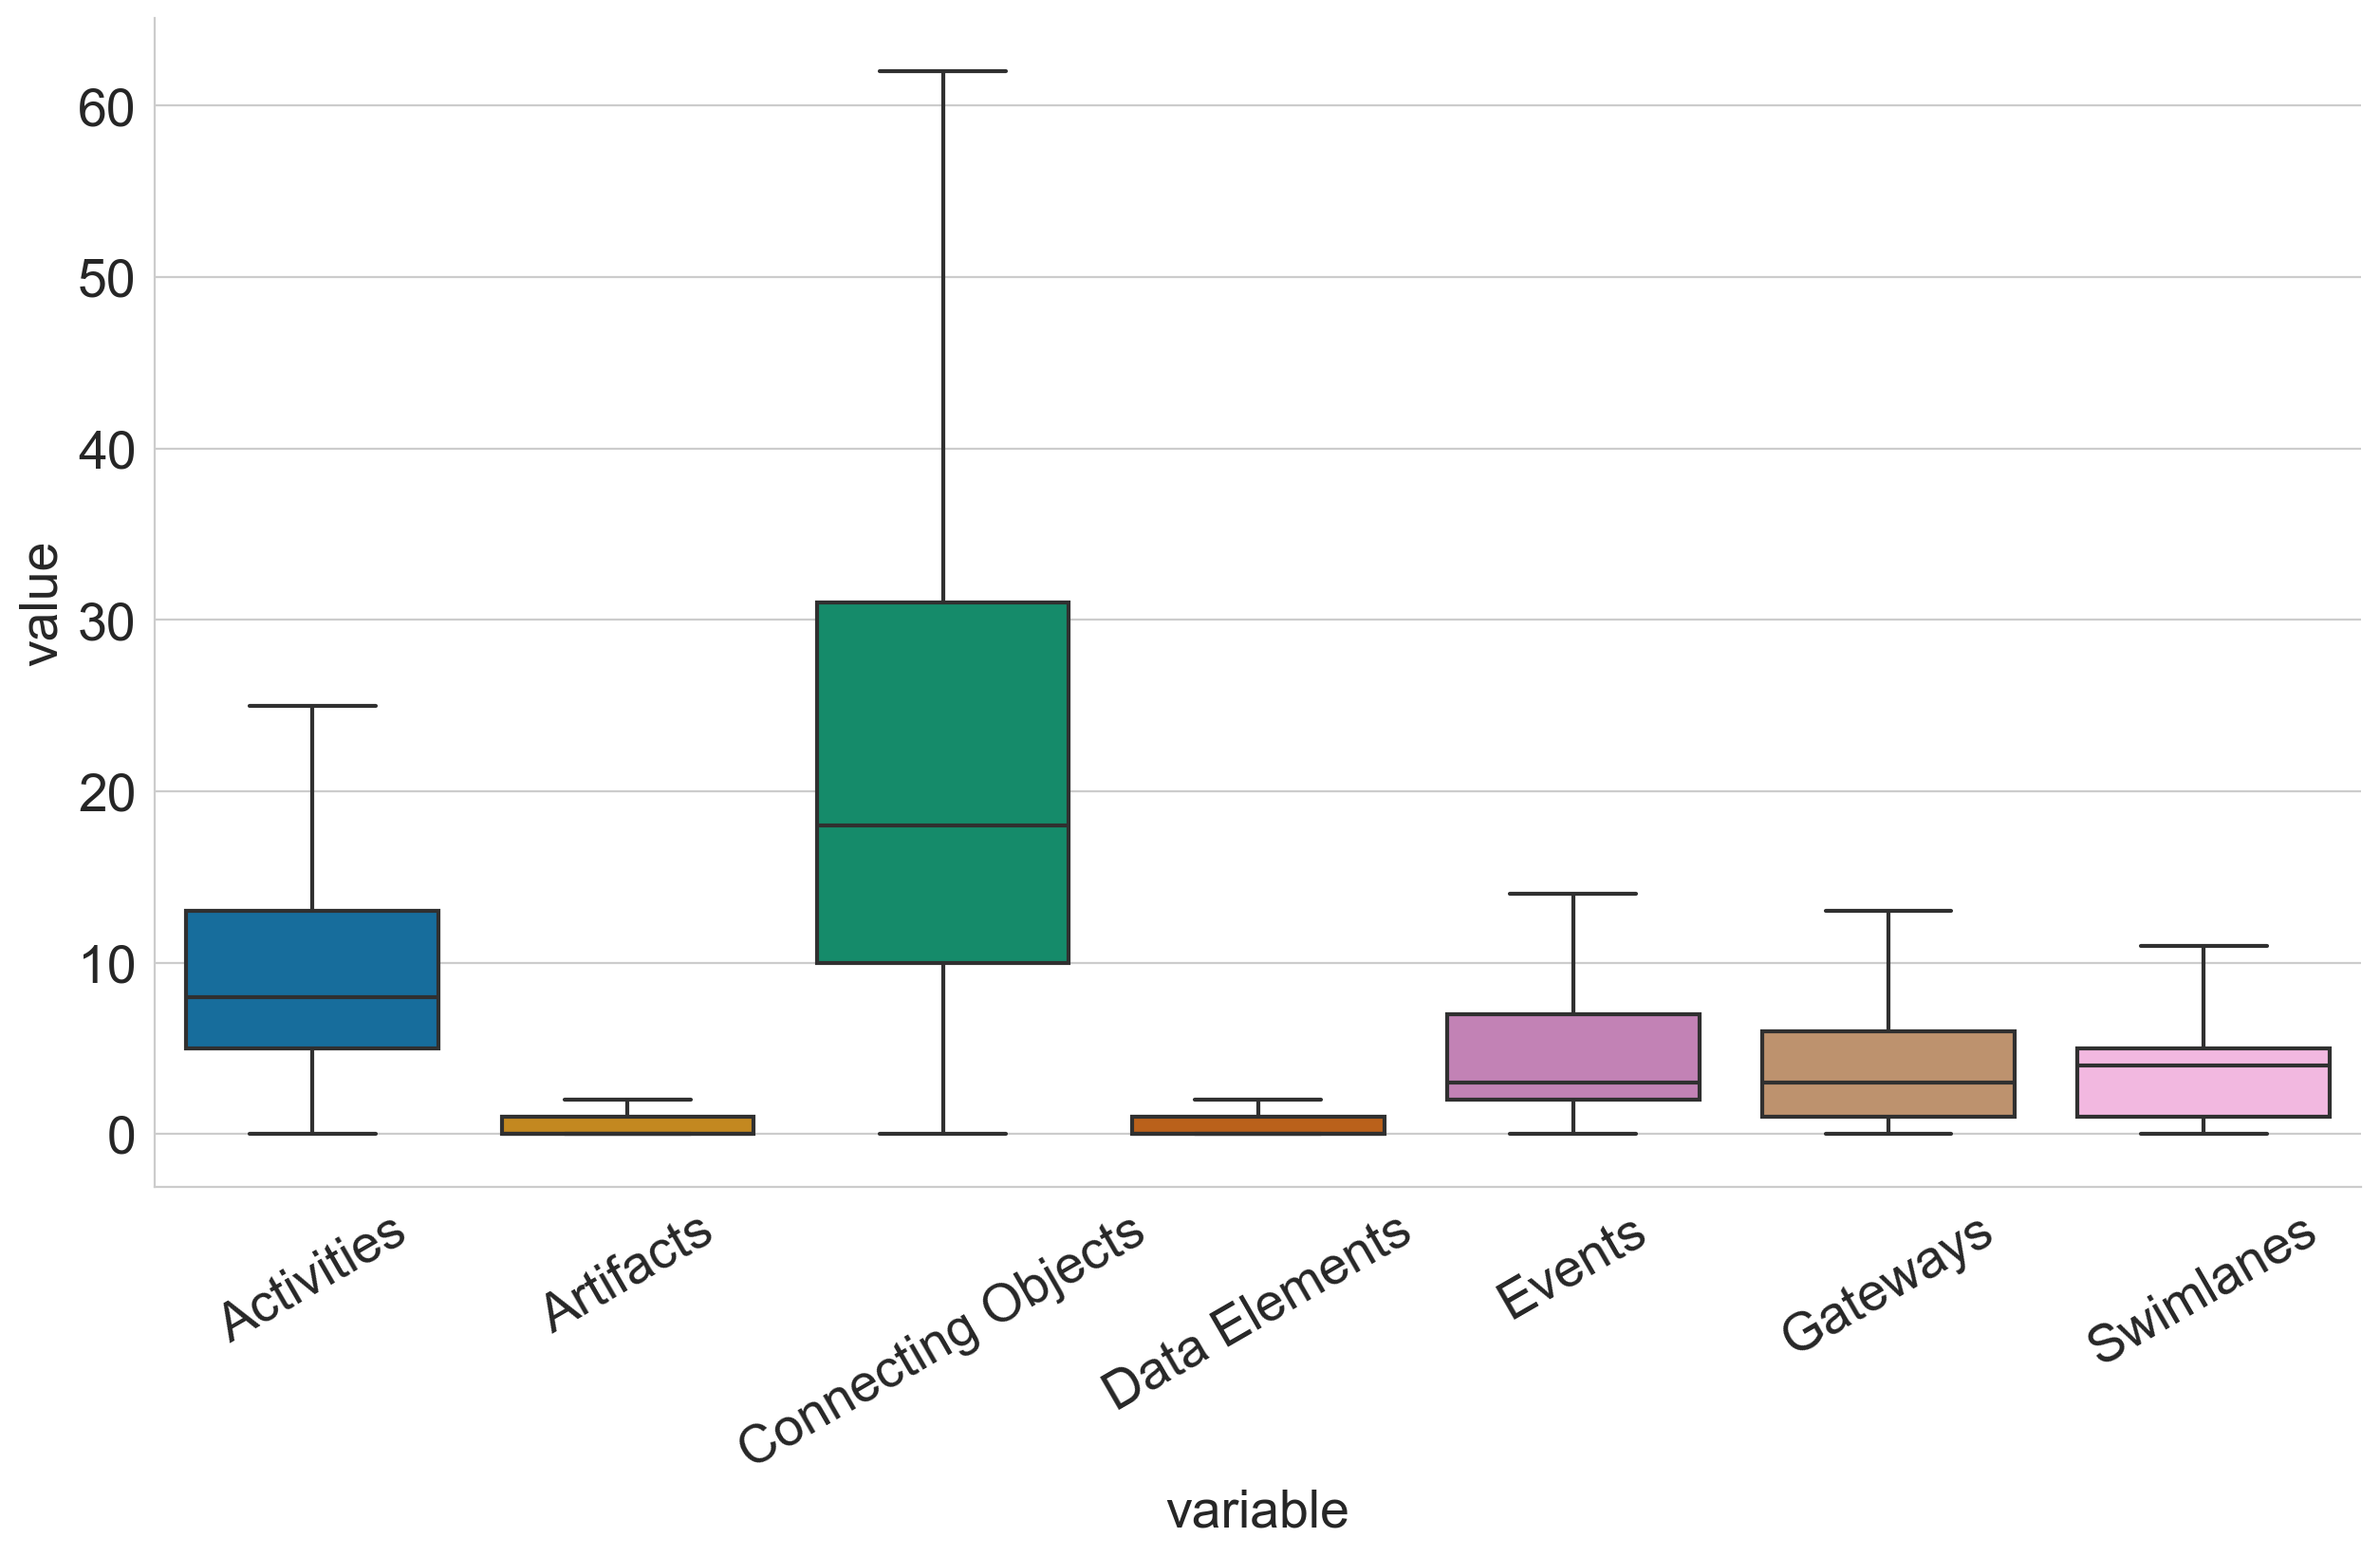

In [70]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [71]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

count       mean        std  min   25%   50%   75%    max
No. of Edges  7624.0  24.884050  25.336164  0.0  10.0  18.0  31.0  480.0
No. of Nodes  7624.0  25.992392  23.433583  0.0  12.0  20.0  32.0  450.0

In [72]:
df_high_level.head()

No. of Edges  No. of Nodes
0            14            13
1            11            14
2            14            15
3             1             4
4            15            17

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

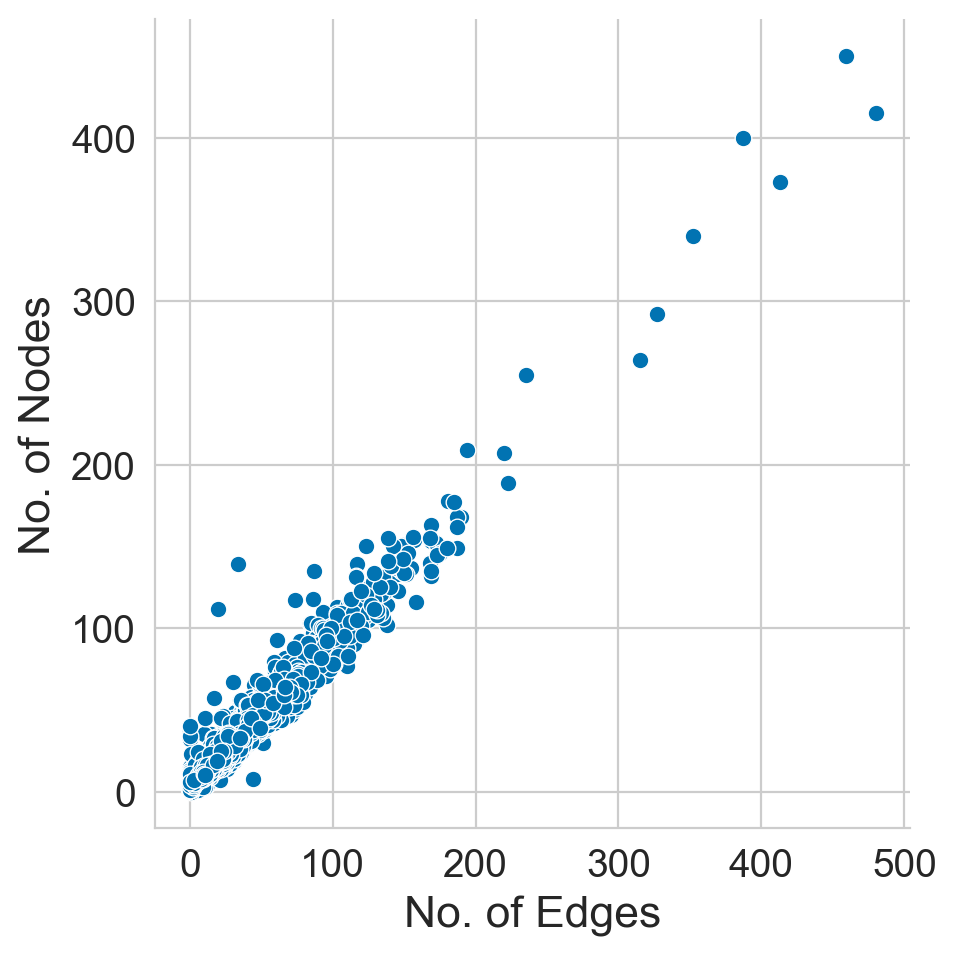

In [73]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [74]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [75]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0       12345678          496
1    New Process          276
2  Neuer Prozess           94
3  12345678_rev1           46
4  12345678_rev2           26
5  12345678_rev3           25
6       Jane Doe           24
7    New Diagram           22
8       Pharmacy           19
9  12345678_rev4           17

The number of distinct process names:

In [76]:
len(cnts_names)

8877

We use Signavio's color palette for the word cloud.

In [77]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

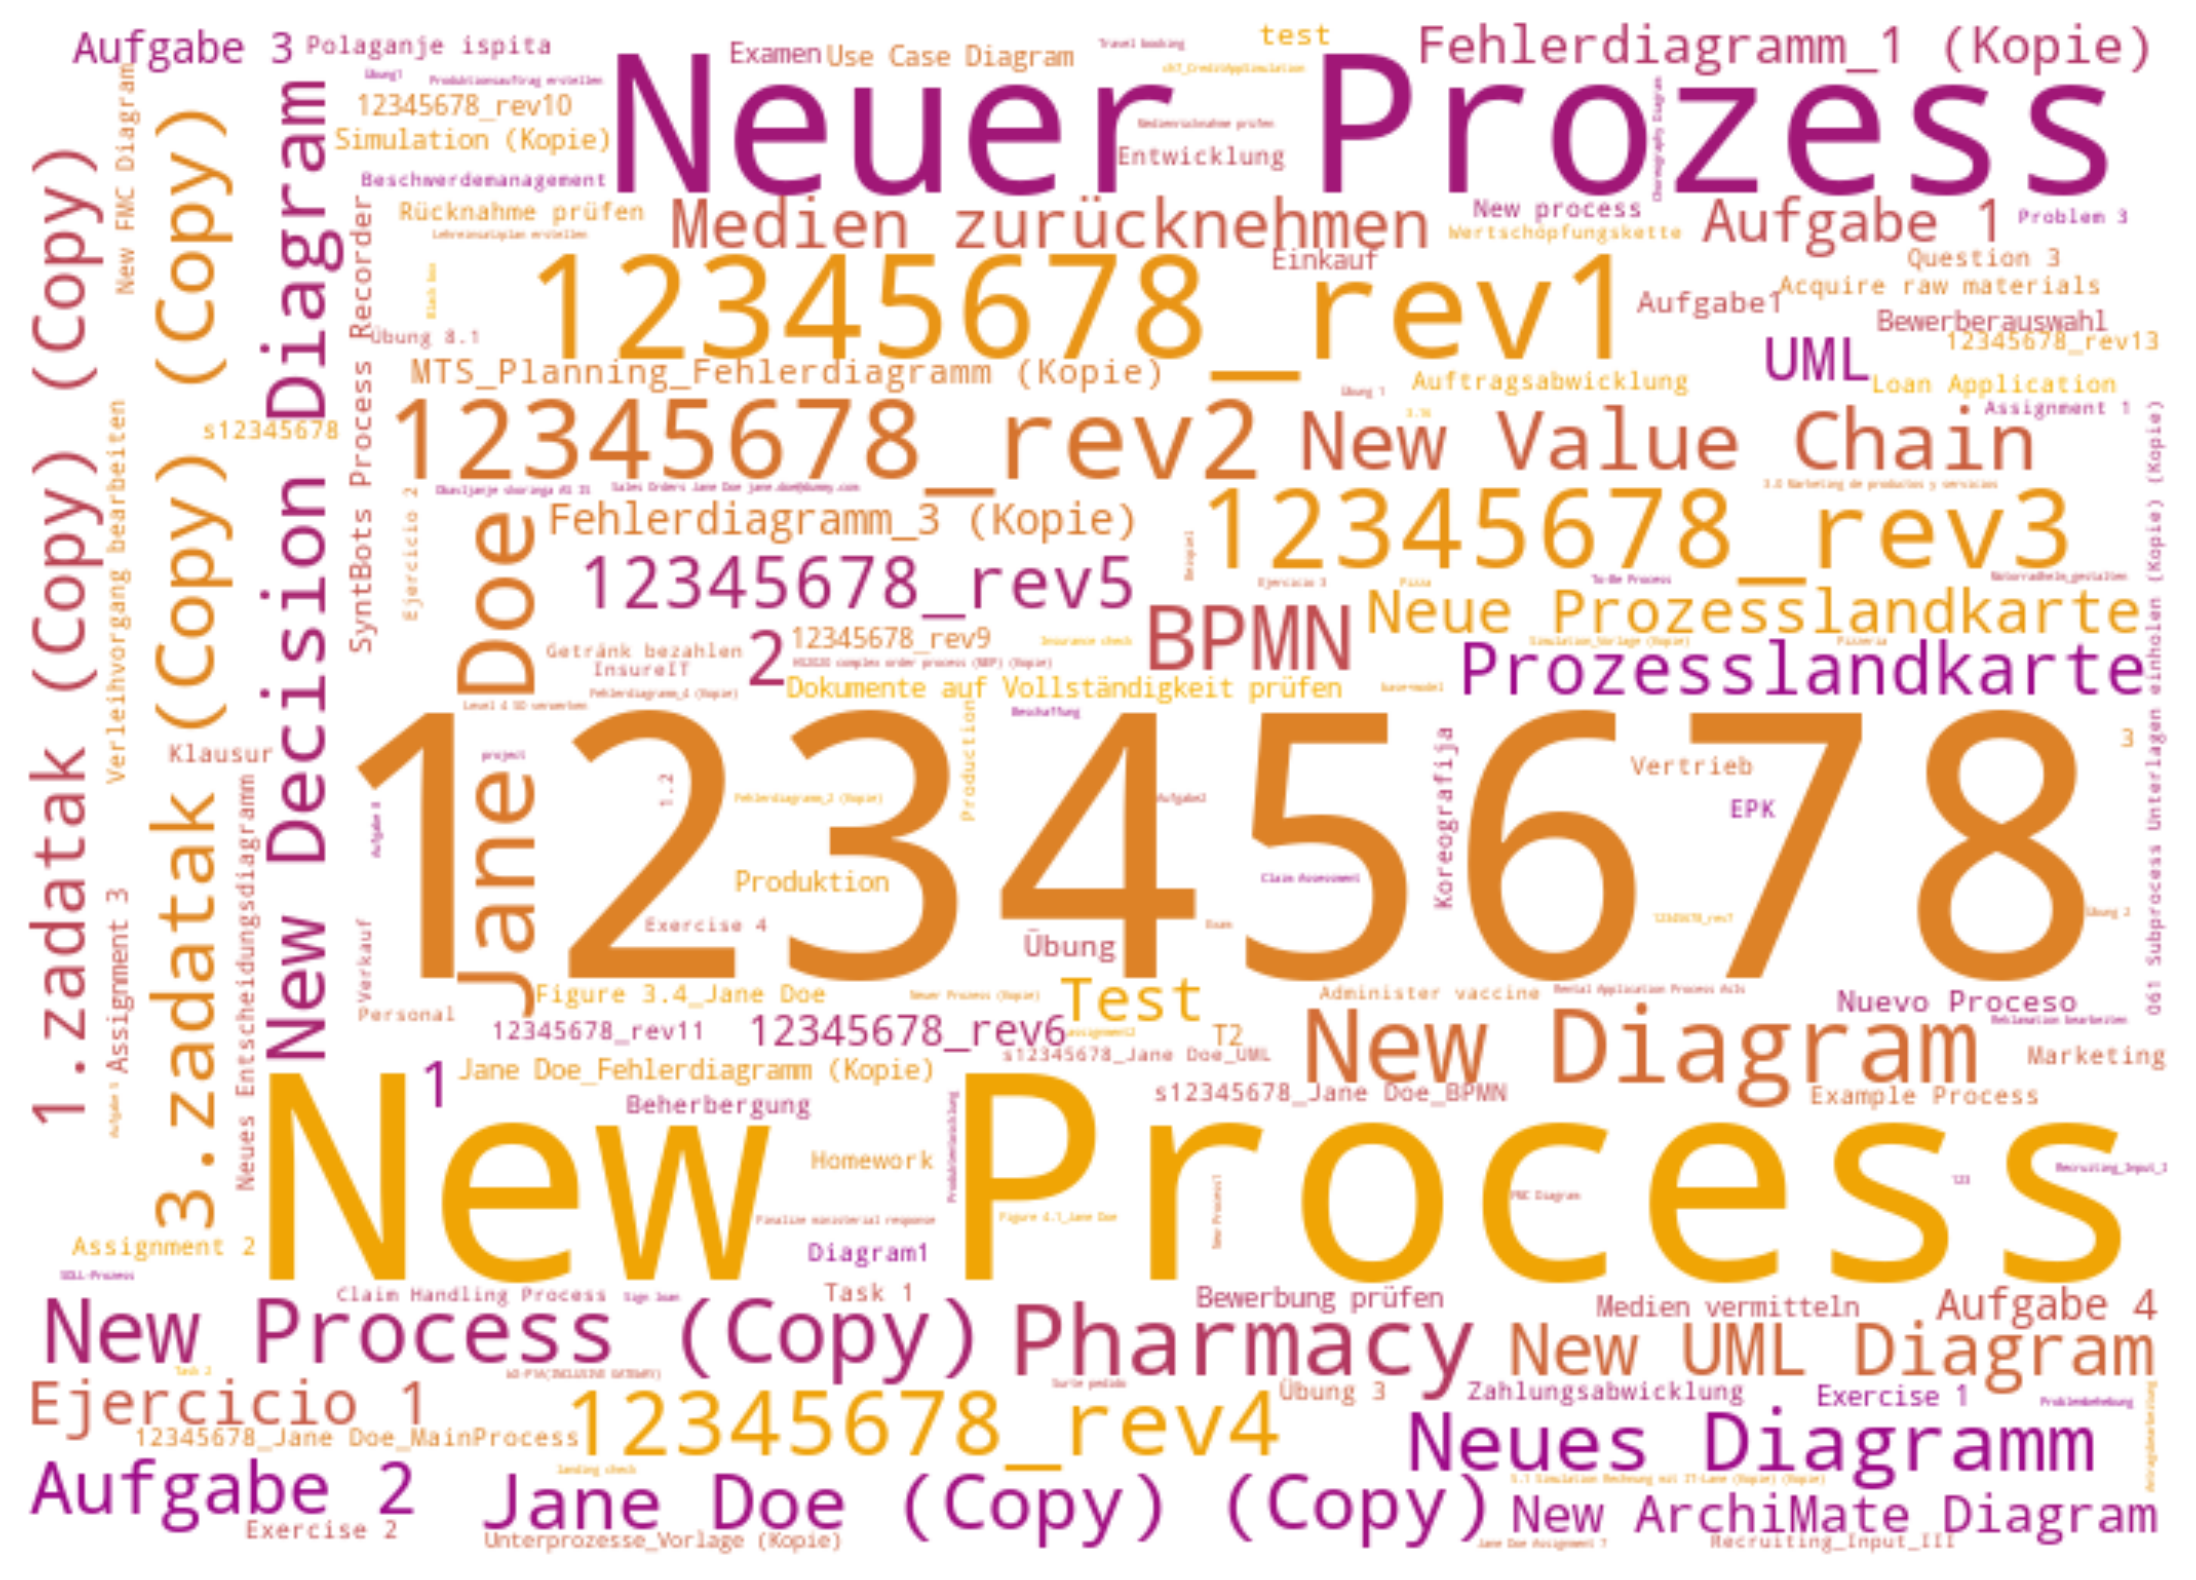

In [78]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [79]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0        No         2122
1       Yes         1729
2        Ja          917
3        no          906
4      Nein          820
5       yes          734
6      nein          732
7        ja          731
8  Customer          487
9        NO          426

The number of distinct element labels:

In [80]:
len(cnts_labels)

117047

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [81]:
len(df_bpmn)

387909

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [82]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.3922635237231792

... while 64.9 % of the labels are used for only one element.

In [83]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.8550496808974173

In [84]:
len(cnts_labels[cnts_labels.occurrences==1])

100081

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [85]:
bins = cnts_labels
bins.head()

label  occurrences
0    No         2122
1   Yes         1729
2    Ja          917
3    no          906
4  Nein          820

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [86]:
N = 10000
bins = bins.groupby(bins.index // N).sum()

In [87]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0        67982           10000
1        16966           20000
2        10000           30000
3        10000           40000
4        10000           50000

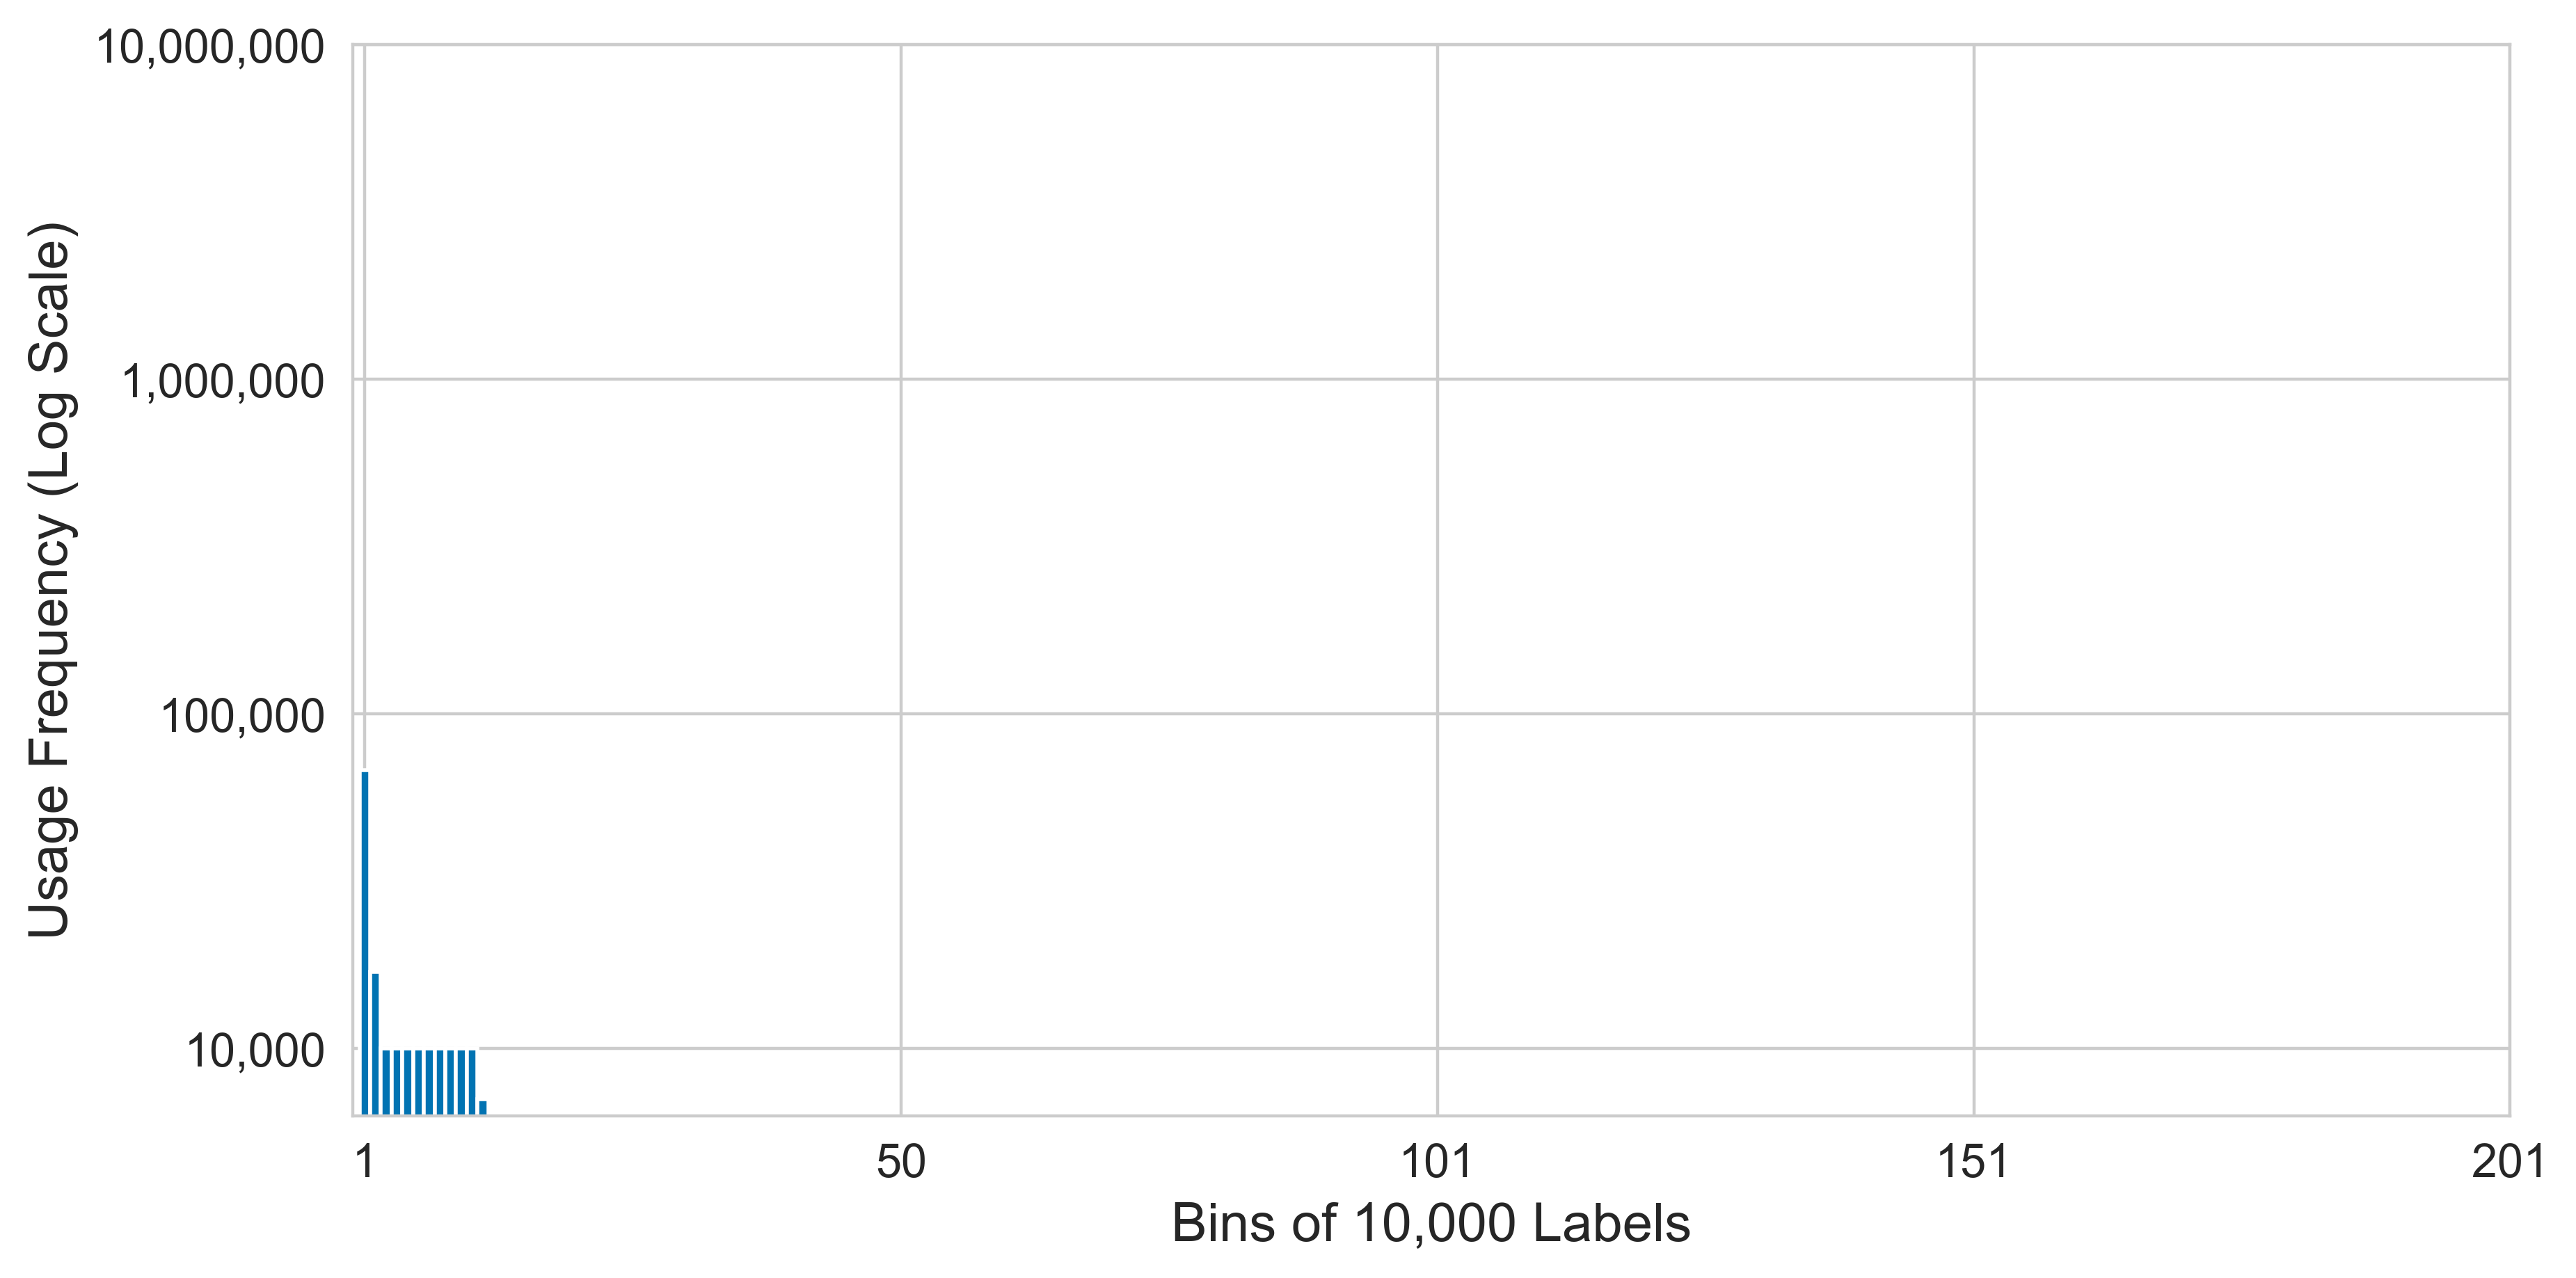

In [88]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

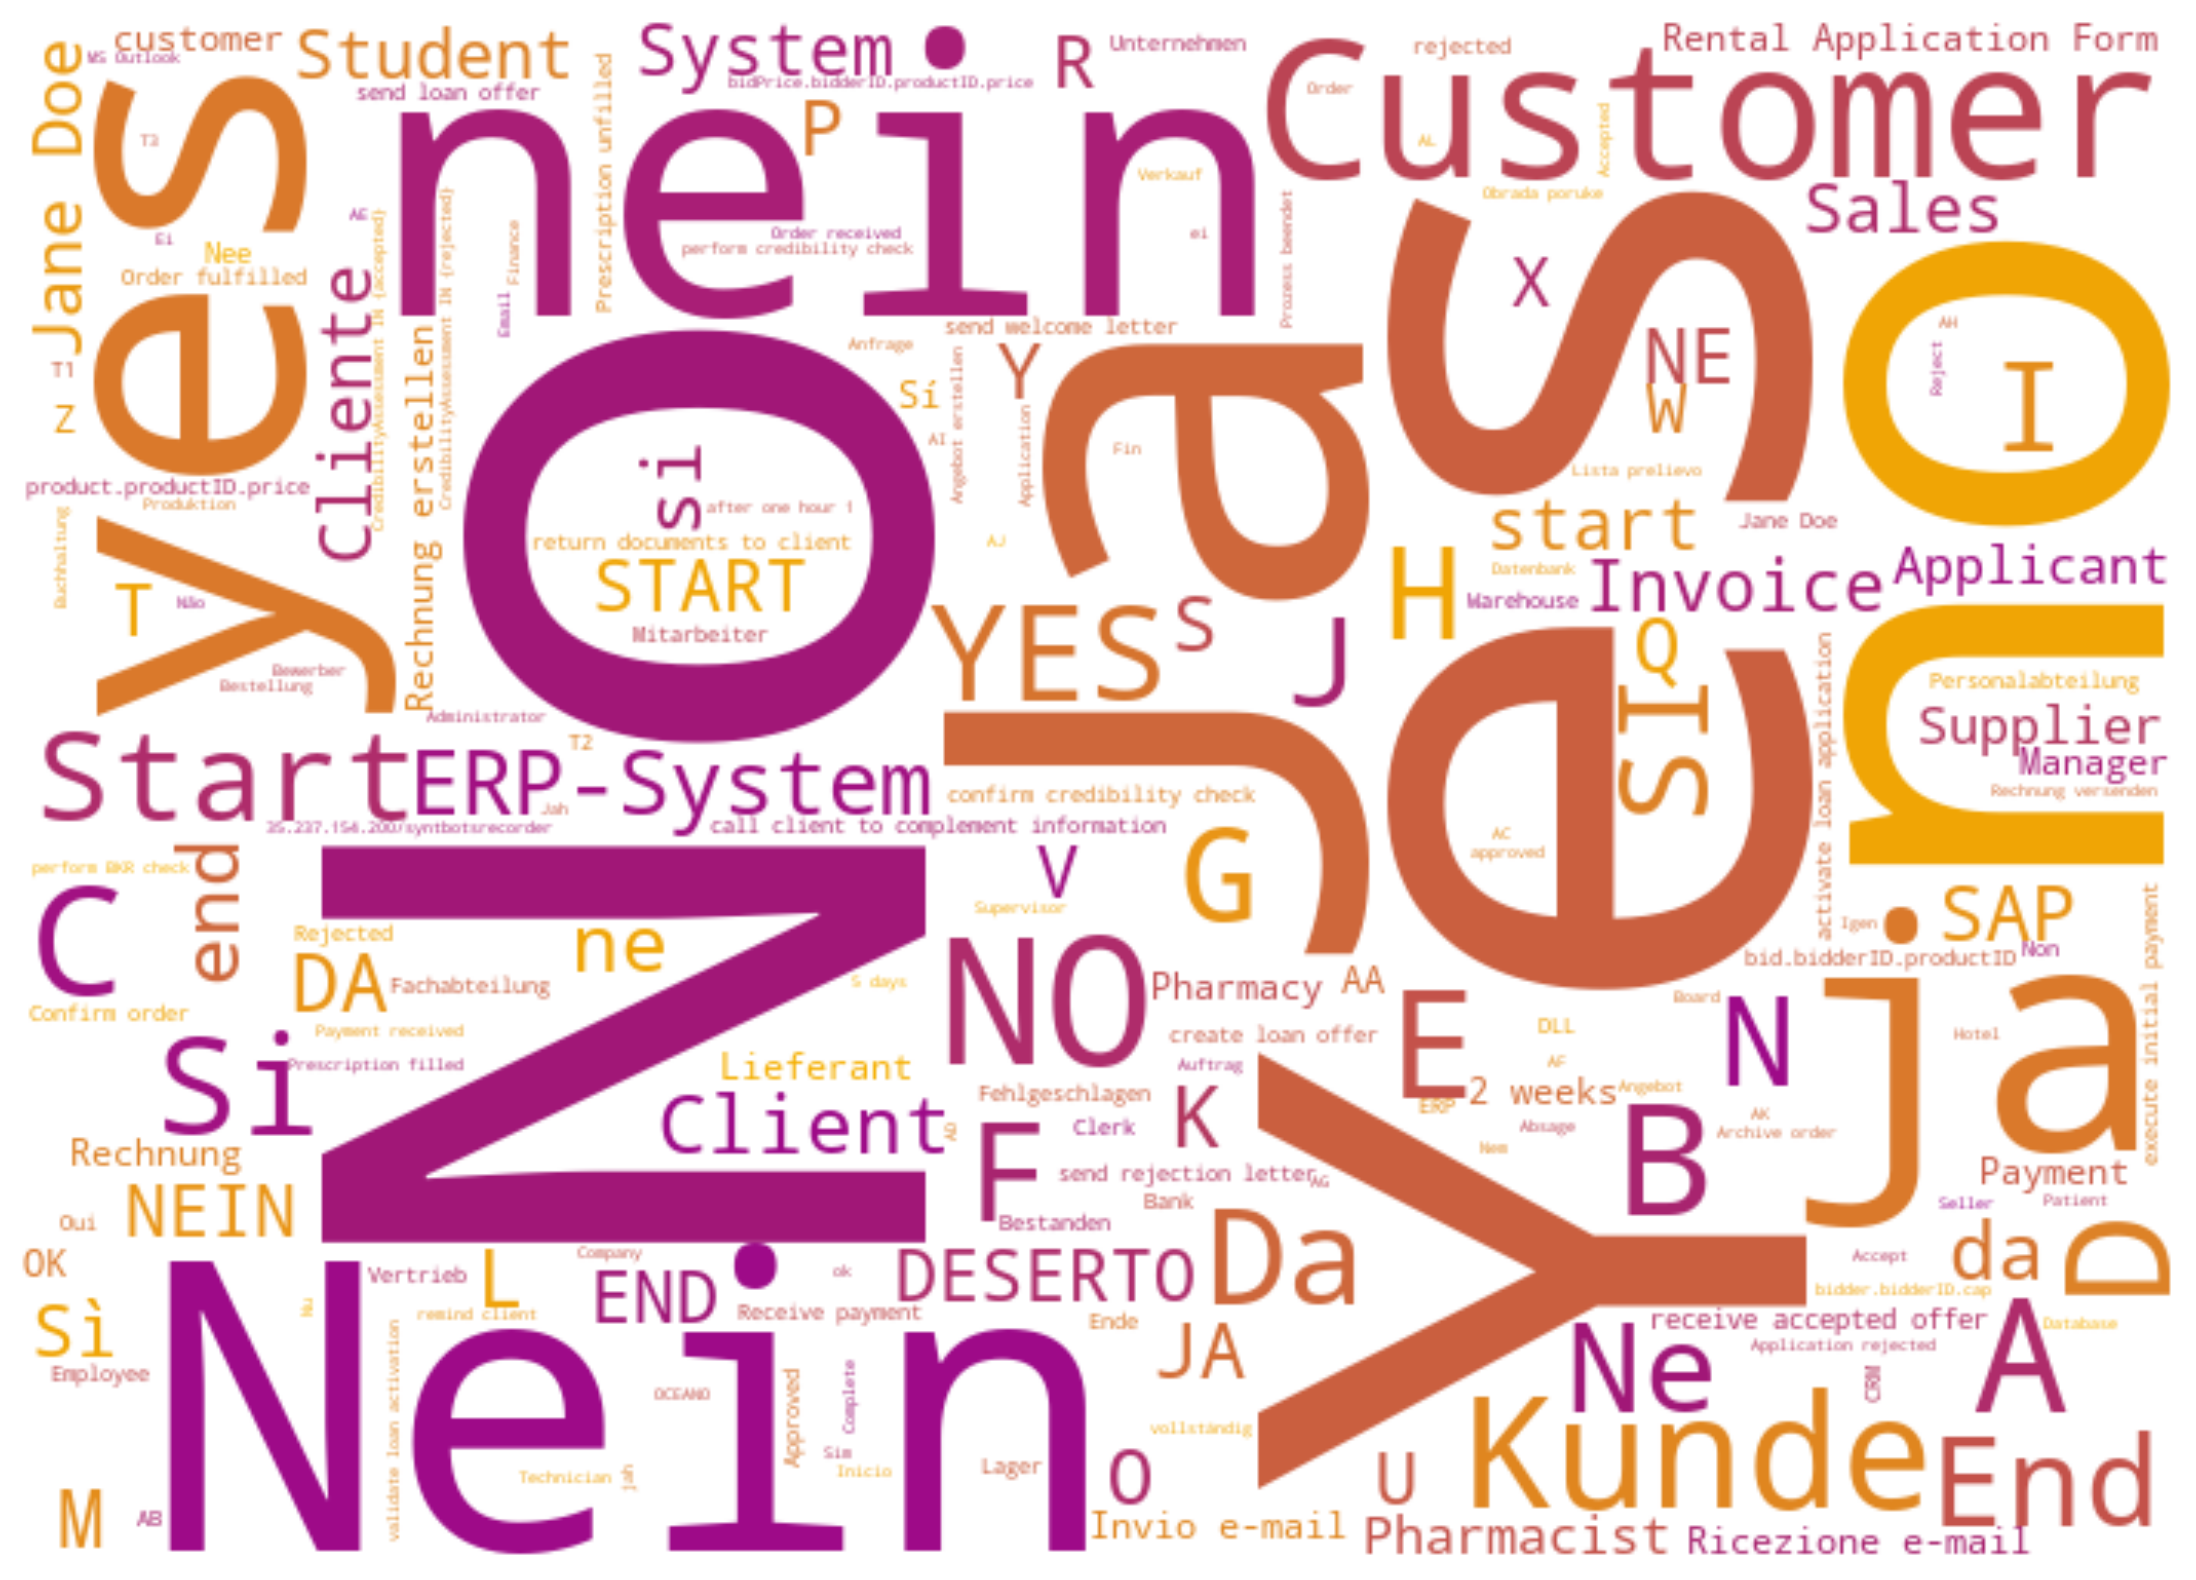

In [89]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()